In [30]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def extract_metrics(log_file, param_keys, max_gpus=2):
    metrics = {
        "overall_latencies": [],
        "overall_throughput": [],
        "request_latencies": [],
        "counts_all": [],
        "request_llm_metrics": [],
        "finished_llm_metrics": [],
        "prefill_ratio": [],
        "ttft_pmetrics": [],
        "tpot_pmetrics": [],
        "latency_pmetrics": []
    }

    param_format = f"Params=\({'(.+?), ' * (len(param_keys)-1)}(.+?)\)"
    patterns = {
        "Overall Latency": ("overall_latencies", f"{param_format} Overall Latency: (.*)"),
        "Overall Throughput": ("overall_throughput", f"{param_format} Overall Throughput: (.*)"),
        "Overall Request Latency": ("request_latencies", f"{param_format} Overall Request Latency: (.*), STD: (.*), P90: (.*)"),
        "Average TTFT": ("request_llm_metrics", f"{param_format} Average TTFT: (.*), Average TOPT: (.*), Throughput ToksPerSec: (.*)"),
        "Num Finished Requests": ("finished_llm_metrics", f"{param_format} Num Finished Requests: (.*), Finished Throughput ToksPerSec: (.*)"),
        "Counts": ("counts_all", f"{param_format} Counts: (.*)"),
        'Overall PrefillRatio': ("prefill_ratio", f"{param_format} Overall PrefillRatio: (.*)"),
        "TTFT": ("ttft_pmetrics", f"{param_format} TTFT p50, p90, p99: (.*),(.*),(.*)"),
        "TPOT": ("tpot_pmetrics", f"{param_format} TPOT p50, p90, p99: (.*),(.*),(.*)"),
        "Latency": ("latency_pmetrics", f"{param_format} Latency p50, p90, p99: (.*),(.*),(.*)")
    }
    
    with open(log_file, 'r') as f:
        for line in f:
            for key, (metric_key, pattern) in patterns.items():
                if key in line:
                    match = re.search(pattern, line)
                    if match:
                        data = {param_key: match.group(i+1) for i, param_key in enumerate(param_keys)}
                        # Parse specific data based on metric type
                        if metric_key == "overall_latencies":
                            data.update({"latency": float(match.group(len(param_keys)+1))})
                        elif metric_key == "overall_throughput":
                            data.update({"throughput": float(match.group(len(param_keys)+1))})
                        elif metric_key == "request_llm_metrics":
                            data.update({"ttft": float(match.group(len(param_keys)+1)), "topt": float(match.group(len(param_keys)+2)), "throughput_tkns_per_sec": float(match.group(len(param_keys)+3))})
                        elif metric_key == "request_latencies":
                            data.update({"avg_latency": float(match.group(len(param_keys)+1)), "std": float(match.group(len(param_keys)+2)), "p90": float(match.group(len(param_keys)+3))})
                        elif metric_key == "finished_llm_metrics":
                            data.update({"num_finished": int(match.group(len(param_keys)+1)), "throughput_finished_tkns_per_sec": float(match.group(len(param_keys)+2))})
                        elif metric_key == "prefill_ratio":
                            data.update({"prefill_ratio": float(match.group(len(param_keys)+1))})
                        elif metric_key == "ttft_pmetrics":
                            data.update({"ttft_p50": float(match.group(len(param_keys)+1)), "ttft_p90": float(match.group(len(param_keys)+2)), "ttft_p99": float(match.group(len(param_keys)+3))})
                        elif metric_key == "tpot_pmetrics":
                            data.update({"tpot_p50": float(match.group(len(param_keys)+1)), "tpot_p90": float(match.group(len(param_keys)+2)), "tpot_p99": float(match.group(len(param_keys)+3))})
                        elif metric_key == "latency_pmetrics":
                            data.update({"latency_p50": float(match.group(len(param_keys)+1)), "latency_p90": float(match.group(len(param_keys)+2)), "latency_p99": float(match.group(len(param_keys)+3))})
                        elif metric_key == "counts_all":
                            # Note: Using eval() can be risky and is generally not recommended
                            count_ratio = eval(match.group(len(param_keys)+1))
                            ratios = {int(k): float(v) for k, v in count_ratio.items()}
                            data.update({"counts_all": ratios, "ratio": ratios[0]/(ratios[0]+ratios[1])})
                        metrics[metric_key].append(data)
    policy_data = collect_policy_data(log_file, max_gpus=max_gpus)
    metrics["scheduling_dynamics"] = policy_data
    return metrics

# Usage example (ensure you replace `log_file` with the actual log file path and adjust `param_keys` as needed)

def prepare_data_for_plotting(metric_data, metric_key, title, policy_replacements=None, group_by_key=None,baseline_key="RANDOM", speedup_direction="lower"):
    df = pd.DataFrame(metric_data)
    if not df.empty:
        df = df.drop(["model_name", "percent_random_prefixes", "exp_time"], axis=1, errors='ignore')
        if policy_replacements:
            # print(df["policy"])
            for original, replacement in policy_replacements.items():
                df['policy'] = df['policy'].str.replace(original, replacement)
        df = df.groupby(['num_prefix', 'num_requests', 'rps', 'policy'])[group_by_key].mean().unstack()
        if baseline_key:
            df = calculate_speedup(df, baseline_policy=baseline_key, speedup_direction=speedup_direction)
        return df, title
    return None, None

def collect_policy_data(log_file, max_gpus=2):
    policy_data = []
    current_policy_info = {}
    max_hit_rate_gpu = {}
    waiting_queue_lengths = []

    def append_policy_data():
        """Helper function to append the current policy's data."""
        if current_policy_info:  # Check if there's data to append
            # Update with GPU hit rates and average waiting queue length
            for gpu_id, hit_rate in max_hit_rate_gpu.items():
                current_policy_info[f'max_tree_cache_hit_rate_gpu{gpu_id}'] = hit_rate
            current_policy_info['avg_waiting_queue_len'] = (
                sum(waiting_queue_lengths) / len(waiting_queue_lengths)
                if waiting_queue_lengths else 0
            )
            policy_data.append(current_policy_info)

    with open(log_file, 'r') as file:
        for line in file:
            if "=====STARTING Policy" in line:
                append_policy_data()  # Append data for the previous policy
                
                # Reset for new policy
                current_policy_info = {}
                max_hit_rate_gpu = {i: 0.0 for i in range(max_gpus)}  # Prepare for up to 8 GPUs
                waiting_queue_lengths = []

                # Extract policy and other properties
                match = re.search(r"=====STARTING Policy (.+?), (\d+) WORKLOADS, ([\d.]+) NON-SHARED, (\d+) REQUESTS, (.*) REQ/s", line)
                if match:
                    current_policy_info = {
                        'policy': match.group(1),
                        'num_prefix': (match.group(2)),
                        'percent_random_prefixes': float(match.group(3)),
                        'num_requests': (match.group(4)),
                        'rps': (match.group(5)),
                    }
                
            elif "tree_cache_hit_rate" in line:
                gpu_id_match = re.search(r"GPU: (\d+)", line)
                hit_rate_match = re.search(r"tree_cache_hit_rate: ([\d.]+)%", line)
                waiting_queue_length_match = re.search(r"#remaining_req: (\d+)", line)

                if waiting_queue_length_match:
                    waiting_queue_lengths.append(int(waiting_queue_length_match.group(1)))

                if gpu_id_match and hit_rate_match:
                    gpu_id = int(gpu_id_match.group(1))
                    hit_rate = float(hit_rate_match.group(1))
                    if gpu_id in max_hit_rate_gpu:
                        max_hit_rate_gpu[gpu_id] = max(max_hit_rate_gpu[gpu_id], hit_rate)

    append_policy_data()  # Append data for the last policy
    for policy in policy_data:
        print(policy)
    return policy_data

def calculate_speedup(df, baseline_policy='RANDOM', speedup_column_name = f"speedup_over_random", speedup_direction="lower"):
    """
    Adds speedup columns to the DataFrame based on metrics compared to a baseline policy.
    
    :param df: DataFrame after groupby().mean().unstack(), where columns are policies.
    :param baseline_policy: The column name for the baseline policy to compare against.
    :param new_column_suffix: Suffix for the new speedup columns.
    """
    df = df.copy()
    if baseline_policy in df.columns:
        for policy in df.columns:
            if policy != baseline_policy:
                if speedup_direction == "lower":
                    df[speedup_column_name] = df[baseline_policy] / df[policy]
                else:
                    df[speedup_column_name] = df[policy] / df[baseline_policy]
            break
    return df

def compare_two_plots(exp1, 
                      exp2, 
                      indices_to_compare, 
                      title_prefix="Node 3 vs Node 4", 
                      labels=['ORACLE_B', 'RANDOM', 'speedup_over_random'], 
                      exp1_title="Node 3",
                      exp2_title="Node 4"):
    # Creating subplots
    fig, axes = plt.subplots(4, 3, figsize=(20, 20))
    axes = axes.flatten()

    plot_configs = []
    for metric_key in exp1.keys():
        for group_by_key in exp1[metric_key].keys():
            plot_configs.append({
                "metric_key": metric_key,
                "group_by_key": group_by_key,
                "ylabel": "Value",
                "title": f"{group_by_key}",
            })

    for i, config in enumerate(plot_configs):
        metric_key = config['metric_key']
        group_by_key = config['group_by_key']
        ylabel = config['ylabel']
        title = config['title']

        for idx in indices_to_compare:
            df_exp1 = exp1[metric_key][group_by_key].loc[idx]
            df_exp2 = exp2[metric_key][group_by_key].loc[idx]
            # Data for plotting
            x = np.arange(len(labels))  # the label locations

            value_exp1 = df_exp1[labels]
            value_exp2 = df_exp2[labels]

            # Plotting
            width = 0.35  # the width of the bars
            rects1 = axes[i].bar(x - width/2, value_exp1, width, label=exp1_title)
            rects2 = axes[i].bar(x + width/2, value_exp2, width, label=exp2_title)

            # Add some text for labels, title, and custom x-axis tick labels, etc.
            axes[i].set_ylabel(ylabel)
            axes[i].set_title(f"{title_prefix} {title}")
            axes[i].set_xticks(x)
            axes[i].set_xticklabels(labels)
            axes[i].legend()

            # Optional: Add autolabel function here to display the height of bars

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

def compare_n_plots(
        experiments, 
        exp_titles, 
        indices_to_compare, 
        title_prefix="Comparison", 
        labels=['ORACLE_B', 'RANDOM', 'speedup_over_random']):
    # Assuming all experiments have the same structure and metrics
    num_experiments = len(experiments)
    
    # Calculating the width of the bars so that all bars fit within each group
    total_width = 0.8  # Total width of the group of bars for each label
    width = total_width / num_experiments  # Width of each individual bar
    
    # Creating subplots
    fig, axes = plt.subplots(4, 3, figsize=(20, 20))
    axes = axes.flatten()

    plot_configs = []
    for metric_key in experiments[0].keys():
        for group_by_key in experiments[0][metric_key].keys():
            plot_configs.append({
                "metric_key": metric_key,
                "group_by_key": group_by_key,
                "ylabel": "Value",
                "title": f"{group_by_key}",
            })
    for i, config in enumerate(plot_configs):
        metric_key = config['metric_key']
        group_by_key = config['group_by_key']
        ylabel = config['ylabel']
        title = config['title']

        x = np.arange(len(labels))  # the label locations
        offset = -total_width / 2 + width / 2  # Starting offset for the first bar
        
        for exp_idx, experiment in enumerate(experiments):
            idx = indices_to_compare[exp_idx]
            df = experiment[metric_key][group_by_key].loc[idx]
            value = df[labels]
            # Plotting
            rects = axes[i].bar(x + offset + exp_idx * width, value, width, label=exp_titles[exp_idx])

        # Add some text for labels, title, and custom x-axis tick labels, etc.
        axes[i].set_ylabel(ylabel)
        axes[i].set_title(f"{title_prefix} {title}")
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(labels)
        axes[i].legend()

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()


def plot_metrics(metrics, title_prefix, ax_dims=(4, 3), figsize=(28, 14), global_metric_dfs={}, global_metric_columns=None, baseline_key = 'RANDOM'):
    fig, axes = plt.subplots(*ax_dims, figsize=figsize)
    plt.tight_layout(pad=12.0)
    
    # Ensure axes is always treated as an array, even when there's only one subplot
    axes = np.array(axes).reshape(-1)  # This handles both single and multiple Axes objects

    plot_configs = [
        # {"metric_key": "overall_latencies", "title": "End to End Latency", "group_by_key": "latency", 'speedup_direction': 'lower', "ylabel": "sec"},
        # {"metric_key": "overall_throughput", "title": "Overall Throughput", "group_by_key": "throughput", 'speedup_direction': 'higher', "ylabel": "reqs/sec"},
        {"metric_key": "request_latencies", "title": "Average per request latency", "group_by_key": "avg_latency", 'speedup_direction': 'lower', "ylabel": "sec"},
        {"metric_key": "request_latencies", "title": "P90 per request latency", "group_by_key": "p90", 'speedup_direction': 'lower', "ylabel": "sec"},
        # TTFT
        {"metric_key": "request_llm_metrics", "title": "TTFT", "group_by_key": "ttft", 'speedup_direction': 'lower', "ylabel": "sec"},
        # TOPT
        {"metric_key": "request_llm_metrics", "title": "TOPT sec/tkn", "group_by_key": "topt", 'speedup_direction': 'lower', "ylabel": "sec/tkn"},
        # throughput_tkns_per_sec
        {"metric_key": "request_llm_metrics", "title": "Total Tokens/sec", "group_by_key": "throughput_tkns_per_sec", 'speedup_direction': 'higher', "ylabel": "tkns/sec"},
        {"metric_key": "finished_llm_metrics", "title": "Num finished 100s", "group_by_key": "num_finished", 'speedup_direction': 'higher', "ylabel": "# of requests"},
        {"metric_key": "counts_all", "title": "Ratio of GPU 0 /(GPU 0 + GPU 1) calls", "group_by_key": "ratio", 'speedup_direction': 'higher', "ylabel": "%"},

        # prefill ratio
        {"metric_key": "prefill_ratio", "title": "Prefill Ratio", "group_by_key": "prefill_ratio", 'speedup_direction': 'lower', "ylabel": "%"},

        # scheduling_dynamics
        {"metric_key": "scheduling_dynamics", "title": "Max Tree Cache Hit Rate GPU 0", "group_by_key": "max_tree_cache_hit_rate_gpu0", 'speedup_direction': 'higher', "ylabel": "%hit"},
        {"metric_key": "scheduling_dynamics", "title": "Avg Waiting Queue Length", "group_by_key": "avg_waiting_queue_len", 'speedup_direction': 'lower', "ylabel": "# requests"},
        # Define additional metric configurations as needed
        {"metric_key": "ttft_pmetrics", "title": "TTFT p50", "group_by_key": "ttft_p50", 'speedup_direction': 'lower', "ylabel": "sec"},
        {"metric_key": "ttft_pmetrics", "title": "TTFT p90", "group_by_key": "ttft_p90", 'speedup_direction': 'lower', "ylabel": "sec"},
        {"metric_key": "ttft_pmetrics", "title": "TTFT p99", "group_by_key": "ttft_p99", 'speedup_direction': 'lower', "ylabel": "sec"},
        {"metric_key": "tpot_pmetrics", "title": "TPOT p50", "group_by_key": "tpot_p50", 'speedup_direction': 'lower', "ylabel": "sec"},
        {"metric_key": "tpot_pmetrics", "title": "TPOT p90", "group_by_key": "tpot_p90", 'speedup_direction': 'lower', "ylabel": "sec"},
        {"metric_key": "tpot_pmetrics", "title": "TPOT p99", "group_by_key": "tpot_p99", 'speedup_direction': 'lower', "ylabel": "sec"},
        {"metric_key": "latency_pmetrics", "title": "Latency p50", "group_by_key": "latency_p50", 'speedup_direction': 'lower', "ylabel": "sec"},
        {"metric_key": "latency_pmetrics", "title": "Latency p90", "group_by_key": "latency_p90", 'speedup_direction': 'lower', "ylabel": "sec"},
        {"metric_key": "latency_pmetrics", "title": "Latency p99", "group_by_key": "latency_p99", 'speedup_direction': 'lower', "ylabel": "sec"},
        
    ]
    
    policy_replacements = {
        'DataParallelRuntimeSelectionPolicy.': '', 
        'CUSTOM-CustomPolicyType.': '', 
        "-":'', 
        "DataParallelRuntimeSelectionPolicy.RANDOM-:": "",
        "BASIC_MEM_SCHEDULERV2:": "",
        "MemSchedulerEvictBasedOnLoad:": "",
        "TBORACLE_B:": "",
        "RANDOM:": ""
        }  # Example replacement
    

    ax_index = 0
    for i, config in enumerate(plot_configs):
        if ax_index >= len(axes):  # Prevent index out of range
            break
        metric_data = metrics.get(config["metric_key"], [])
        df, title = prepare_data_for_plotting(
            metric_data, 
            config["metric_key"], 
            config["title"], 
            policy_replacements, 
            speedup_direction=config.get('speedup_direction', 'lower'),
            group_by_key=config.get("group_by_key"),
            baseline_key=baseline_key) 
        if df is not None:
            if config["metric_key"] not in global_metric_dfs:
                global_metric_dfs[config["metric_key"]] = {}
            global_metric_dfs[config["metric_key"]][config["group_by_key"]] = df  # Store dataframe globally
            ax = axes[ax_index]
            if global_metric_columns:
                metric_columns = global_metric_columns
            else:
                metric_columns = [col for col in df.columns if 'speedup_over_random' != col]
            bars = df[metric_columns].plot(kind='bar', ax=ax, title=f"{title_prefix} {title}", rot=0, ylabel={config["ylabel"]}, legend=(i == 0))
            if 'speedup_over_random' in df.columns:
                for bar, speedup in zip(bars.get_children(), df['speedup_over_random']):
                    if pd.notna(speedup):  # Check if speedup value exists and is not NaN
                        height = bar.get_height()
                        ax.annotate(f'{speedup:.2f}x',
                                    xy=(bar.get_x() + bar.get_width() / 2, height),
                                    xytext=(0, -3),  # 3 points vertical offset
                                    textcoords="offset points",
                                    ha='center', va='bottom')
            x_labels = []
            for idx in df[metric_columns].index:
                label = '\n'.join(str(val) for val in idx)
                x_labels.append(label)
            bars.set_xticklabels(x_labels)
            ax_index += 1

            # Customize the plot as needed

    # Hide unused subplots
    for i in range(ax_index, len(axes)):
        fig.delaxes(axes[i])


{'policy': 'DataParallelRuntimeSelectionPolicy.CUSTOM-CustomPolicyType.GREEDY_LP:greedy', 'num_prefix': '800', 'percent_random_prefixes': 0.0, 'num_requests': '2400', 'rps': '24', 'max_tree_cache_hit_rate_gpu0': 41.72, 'max_tree_cache_hit_rate_gpu1': 45.24, 'max_tree_cache_hit_rate_gpu2': 44.75, 'max_tree_cache_hit_rate_gpu3': 43.21, 'max_tree_cache_hit_rate_gpu4': 45.34, 'max_tree_cache_hit_rate_gpu5': 44.64, 'max_tree_cache_hit_rate_gpu6': 46.4, 'max_tree_cache_hit_rate_gpu7': 47.85, 'avg_waiting_queue_len': 0.0}
{'policy': 'DataParallelRuntimeSelectionPolicy.RANDOM-:random', 'num_prefix': '800', 'percent_random_prefixes': 0.0, 'num_requests': '2400', 'rps': '24', 'max_tree_cache_hit_rate_gpu0': 22.85, 'max_tree_cache_hit_rate_gpu1': 21.24, 'max_tree_cache_hit_rate_gpu2': 26.01, 'max_tree_cache_hit_rate_gpu3': 20.98, 'max_tree_cache_hit_rate_gpu4': 23.58, 'max_tree_cache_hit_rate_gpu5': 24.47, 'max_tree_cache_hit_rate_gpu6': 23.26, 'max_tree_cache_hit_rate_gpu7': 24.99, 'avg_waiting_

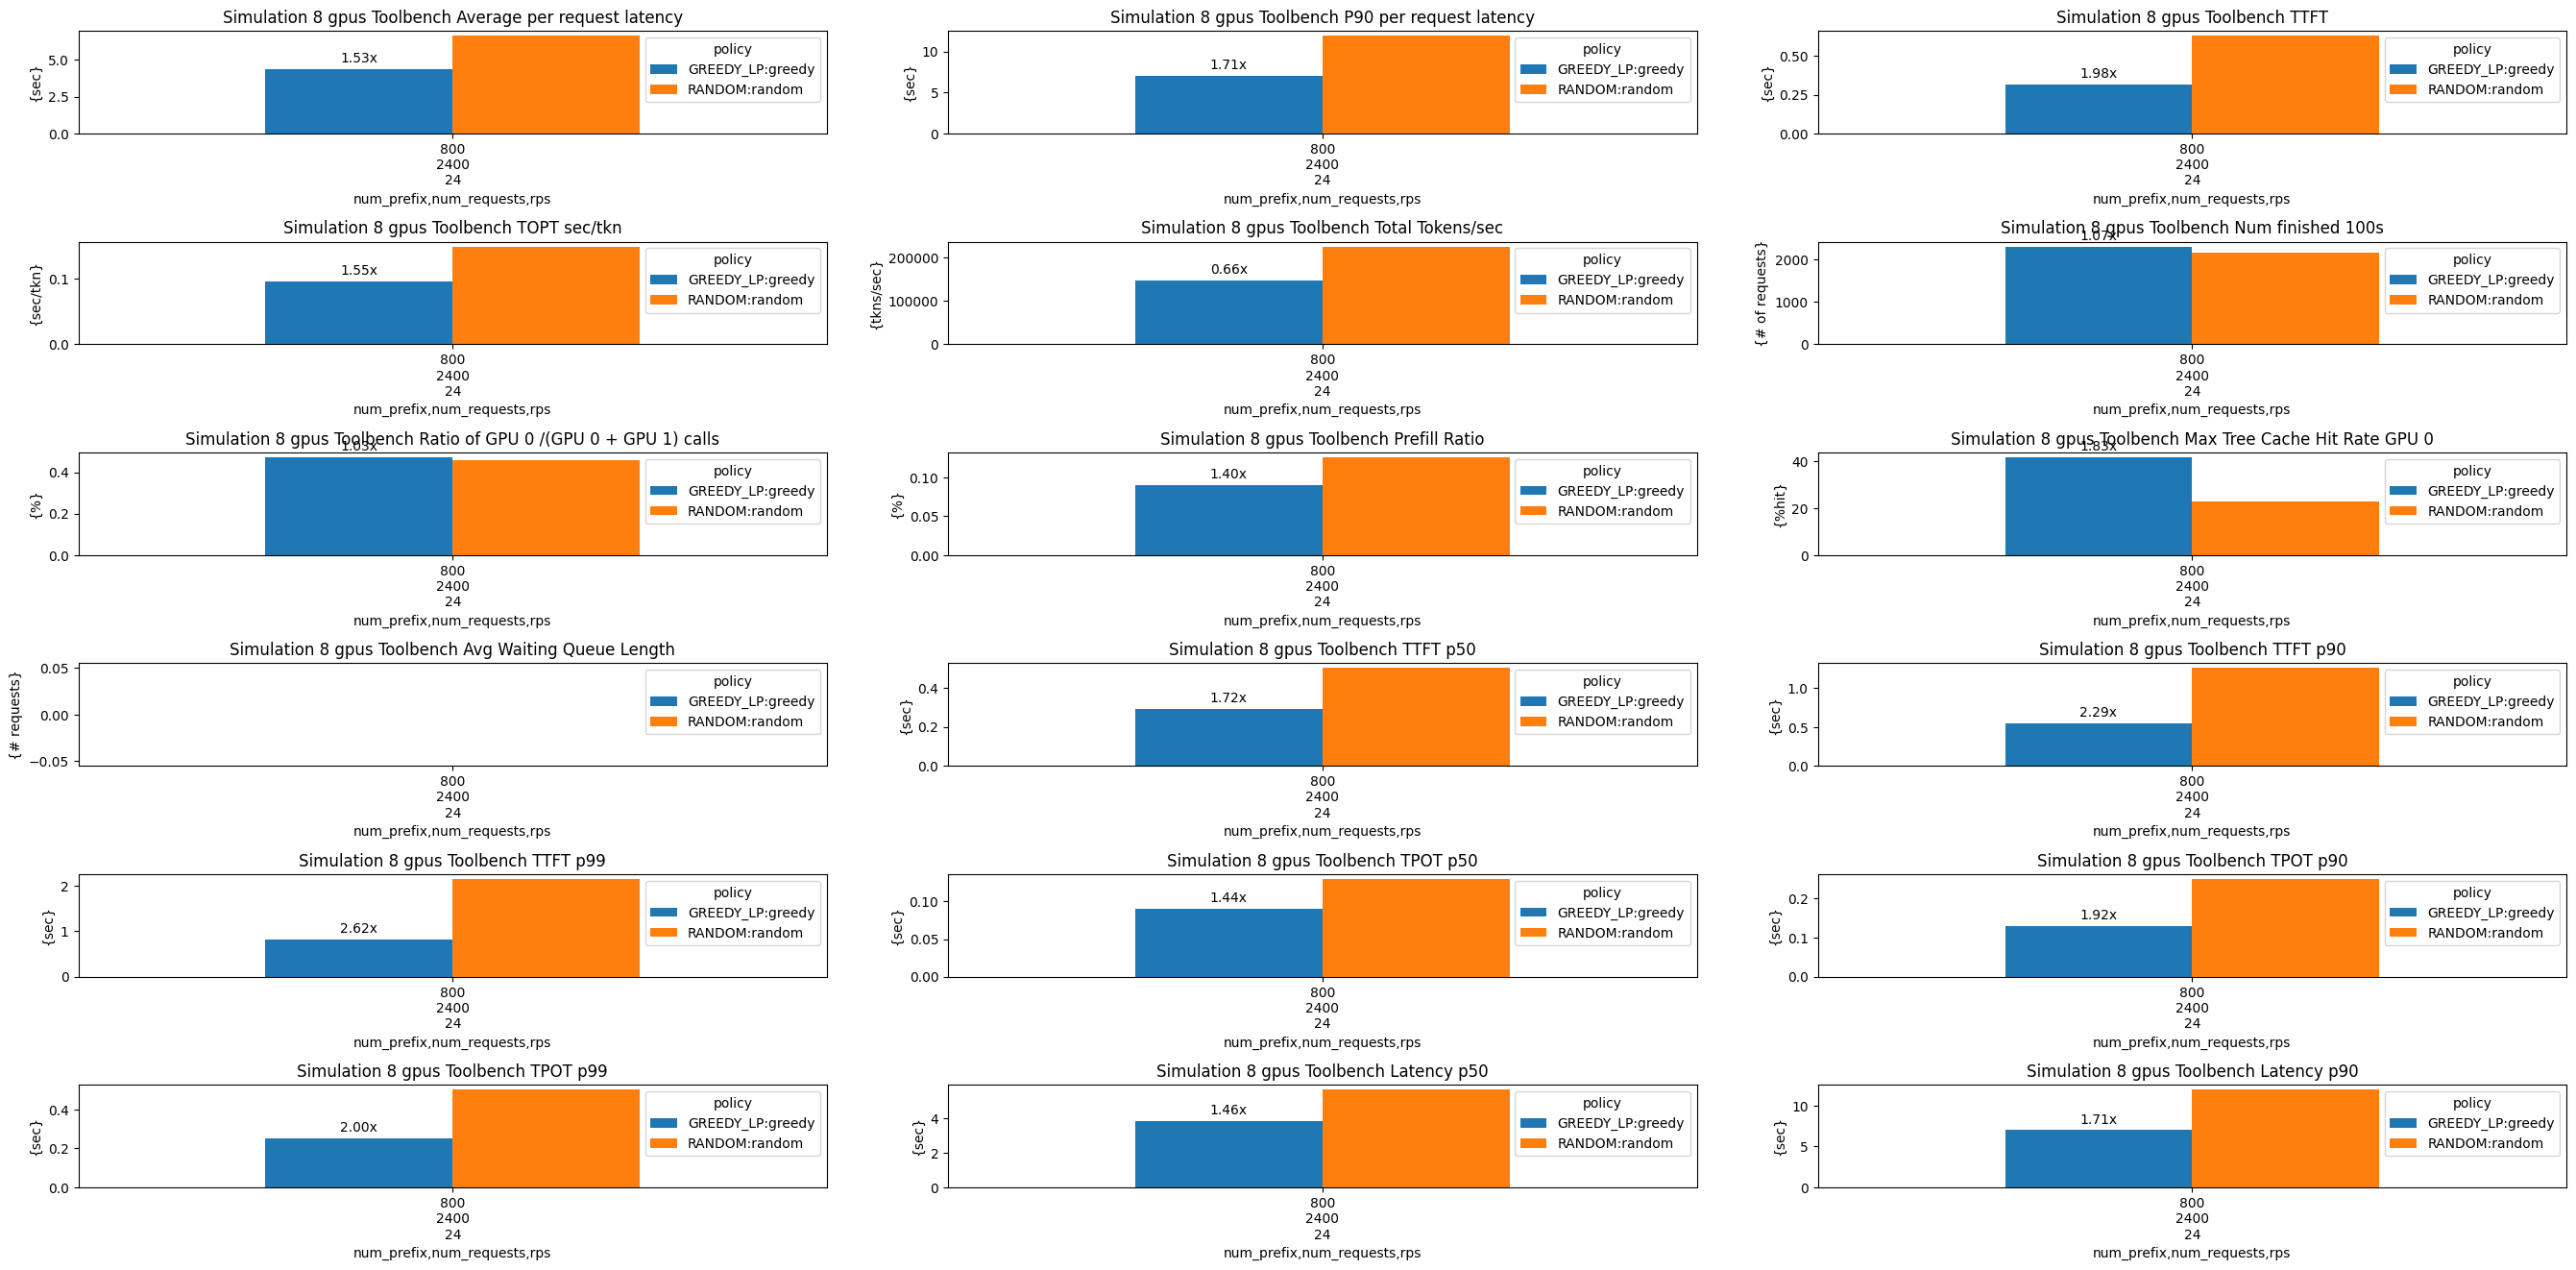

In [69]:
log_file = 'logs_sim/toolbench_4096_simulated_8_gpus.log'
param_keys = ["model_name", "num_prefix", "percent_random_prefixes", "num_requests", "rps", "policy", "exp_time"]
metrics = extract_metrics(log_file, param_keys, max_gpus=8)
node_3_exp = {}
plot_metrics(metrics, "Simulation 8 gpus Toolbench", global_metric_dfs=node_3_exp, baseline_key="RANDOM:random", ax_dims=(6,3))

{'policy': 'DataParallelRuntimeSelectionPolicy.CUSTOM-CustomPolicyType.GREEDY_LP:greedy', 'num_prefix': '400', 'percent_random_prefixes': 0.0, 'num_requests': '1200', 'rps': '12', 'max_tree_cache_hit_rate_gpu0': 46.44, 'max_tree_cache_hit_rate_gpu1': 45.13, 'max_tree_cache_hit_rate_gpu2': 48.08, 'max_tree_cache_hit_rate_gpu3': 48.36, 'avg_waiting_queue_len': 0.0}
{'policy': 'DataParallelRuntimeSelectionPolicy.RANDOM-:random', 'num_prefix': '400', 'percent_random_prefixes': 0.0, 'num_requests': '1200', 'rps': '12', 'max_tree_cache_hit_rate_gpu0': 27.22, 'max_tree_cache_hit_rate_gpu1': 30.91, 'max_tree_cache_hit_rate_gpu2': 28.37, 'max_tree_cache_hit_rate_gpu3': 30.03, 'avg_waiting_queue_len': 0.0}


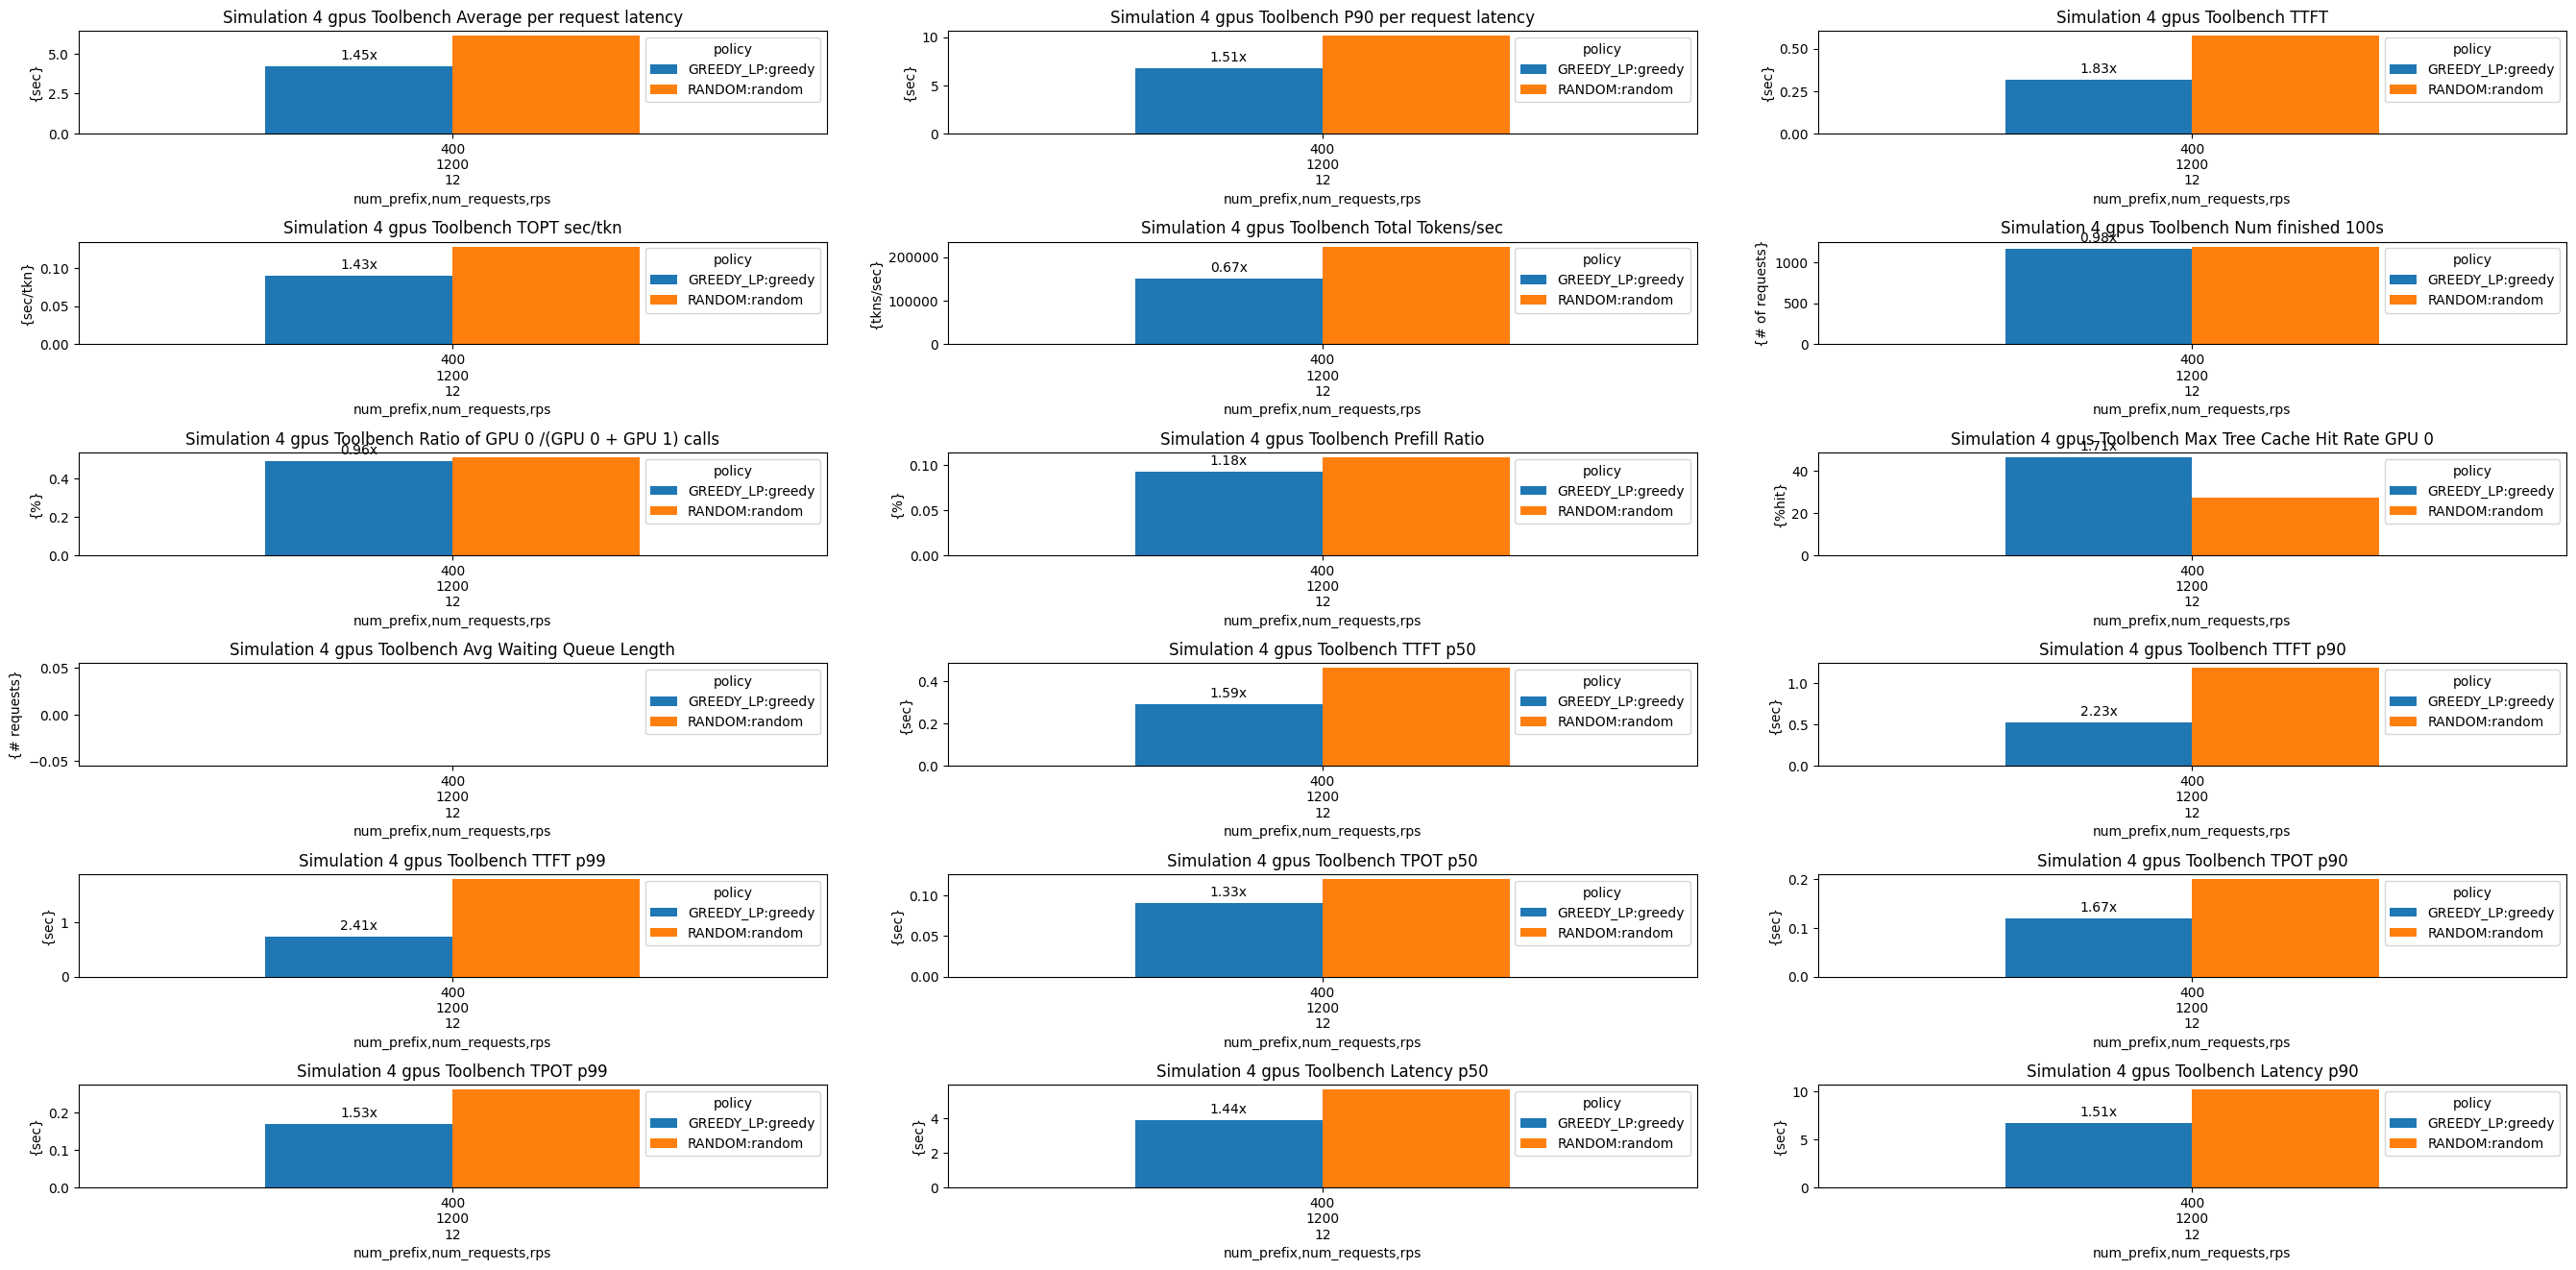

In [71]:
log_file = 'logs_sim/toolbench_4096_simulated_4_gpus.log'
param_keys = ["model_name", "num_prefix", "percent_random_prefixes", "num_requests", "rps", "policy", "exp_time"]
metrics = extract_metrics(log_file, param_keys, max_gpus=4)
node_3_exp = {}
plot_metrics(metrics, "Simulation 4 gpus Toolbench", global_metric_dfs=node_3_exp, baseline_key="RANDOM:random", ax_dims=(6,3))

{'policy': 'DataParallelRuntimeSelectionPolicy.CUSTOM-CustomPolicyType.GREEDY_LP:greedy', 'num_prefix': '400', 'percent_random_prefixes': 0.0, 'num_requests': '1200', 'rps': '12', 'max_tree_cache_hit_rate_gpu0': 48.6, 'max_tree_cache_hit_rate_gpu1': 48.91, 'max_tree_cache_hit_rate_gpu2': 0.0, 'max_tree_cache_hit_rate_gpu3': 0.0, 'avg_waiting_queue_len': 0.0}
{'policy': 'DataParallelRuntimeSelectionPolicy.CUSTOM-CustomPolicyType.GREEDY_LP:greedy', 'num_prefix': '400', 'percent_random_prefixes': 0.0, 'num_requests': '1200', 'rps': '12', 'max_tree_cache_hit_rate_gpu0': 48.34, 'max_tree_cache_hit_rate_gpu1': 49.1, 'max_tree_cache_hit_rate_gpu2': 0.0, 'max_tree_cache_hit_rate_gpu3': 0.0, 'avg_waiting_queue_len': 0.0}
{'policy': 'DataParallelRuntimeSelectionPolicy.RANDOM-:random', 'num_prefix': '400', 'percent_random_prefixes': 0.0, 'num_requests': '1200', 'rps': '12', 'max_tree_cache_hit_rate_gpu0': 27.88, 'max_tree_cache_hit_rate_gpu1': 22.79, 'max_tree_cache_hit_rate_gpu2': 0.0, 'max_tree

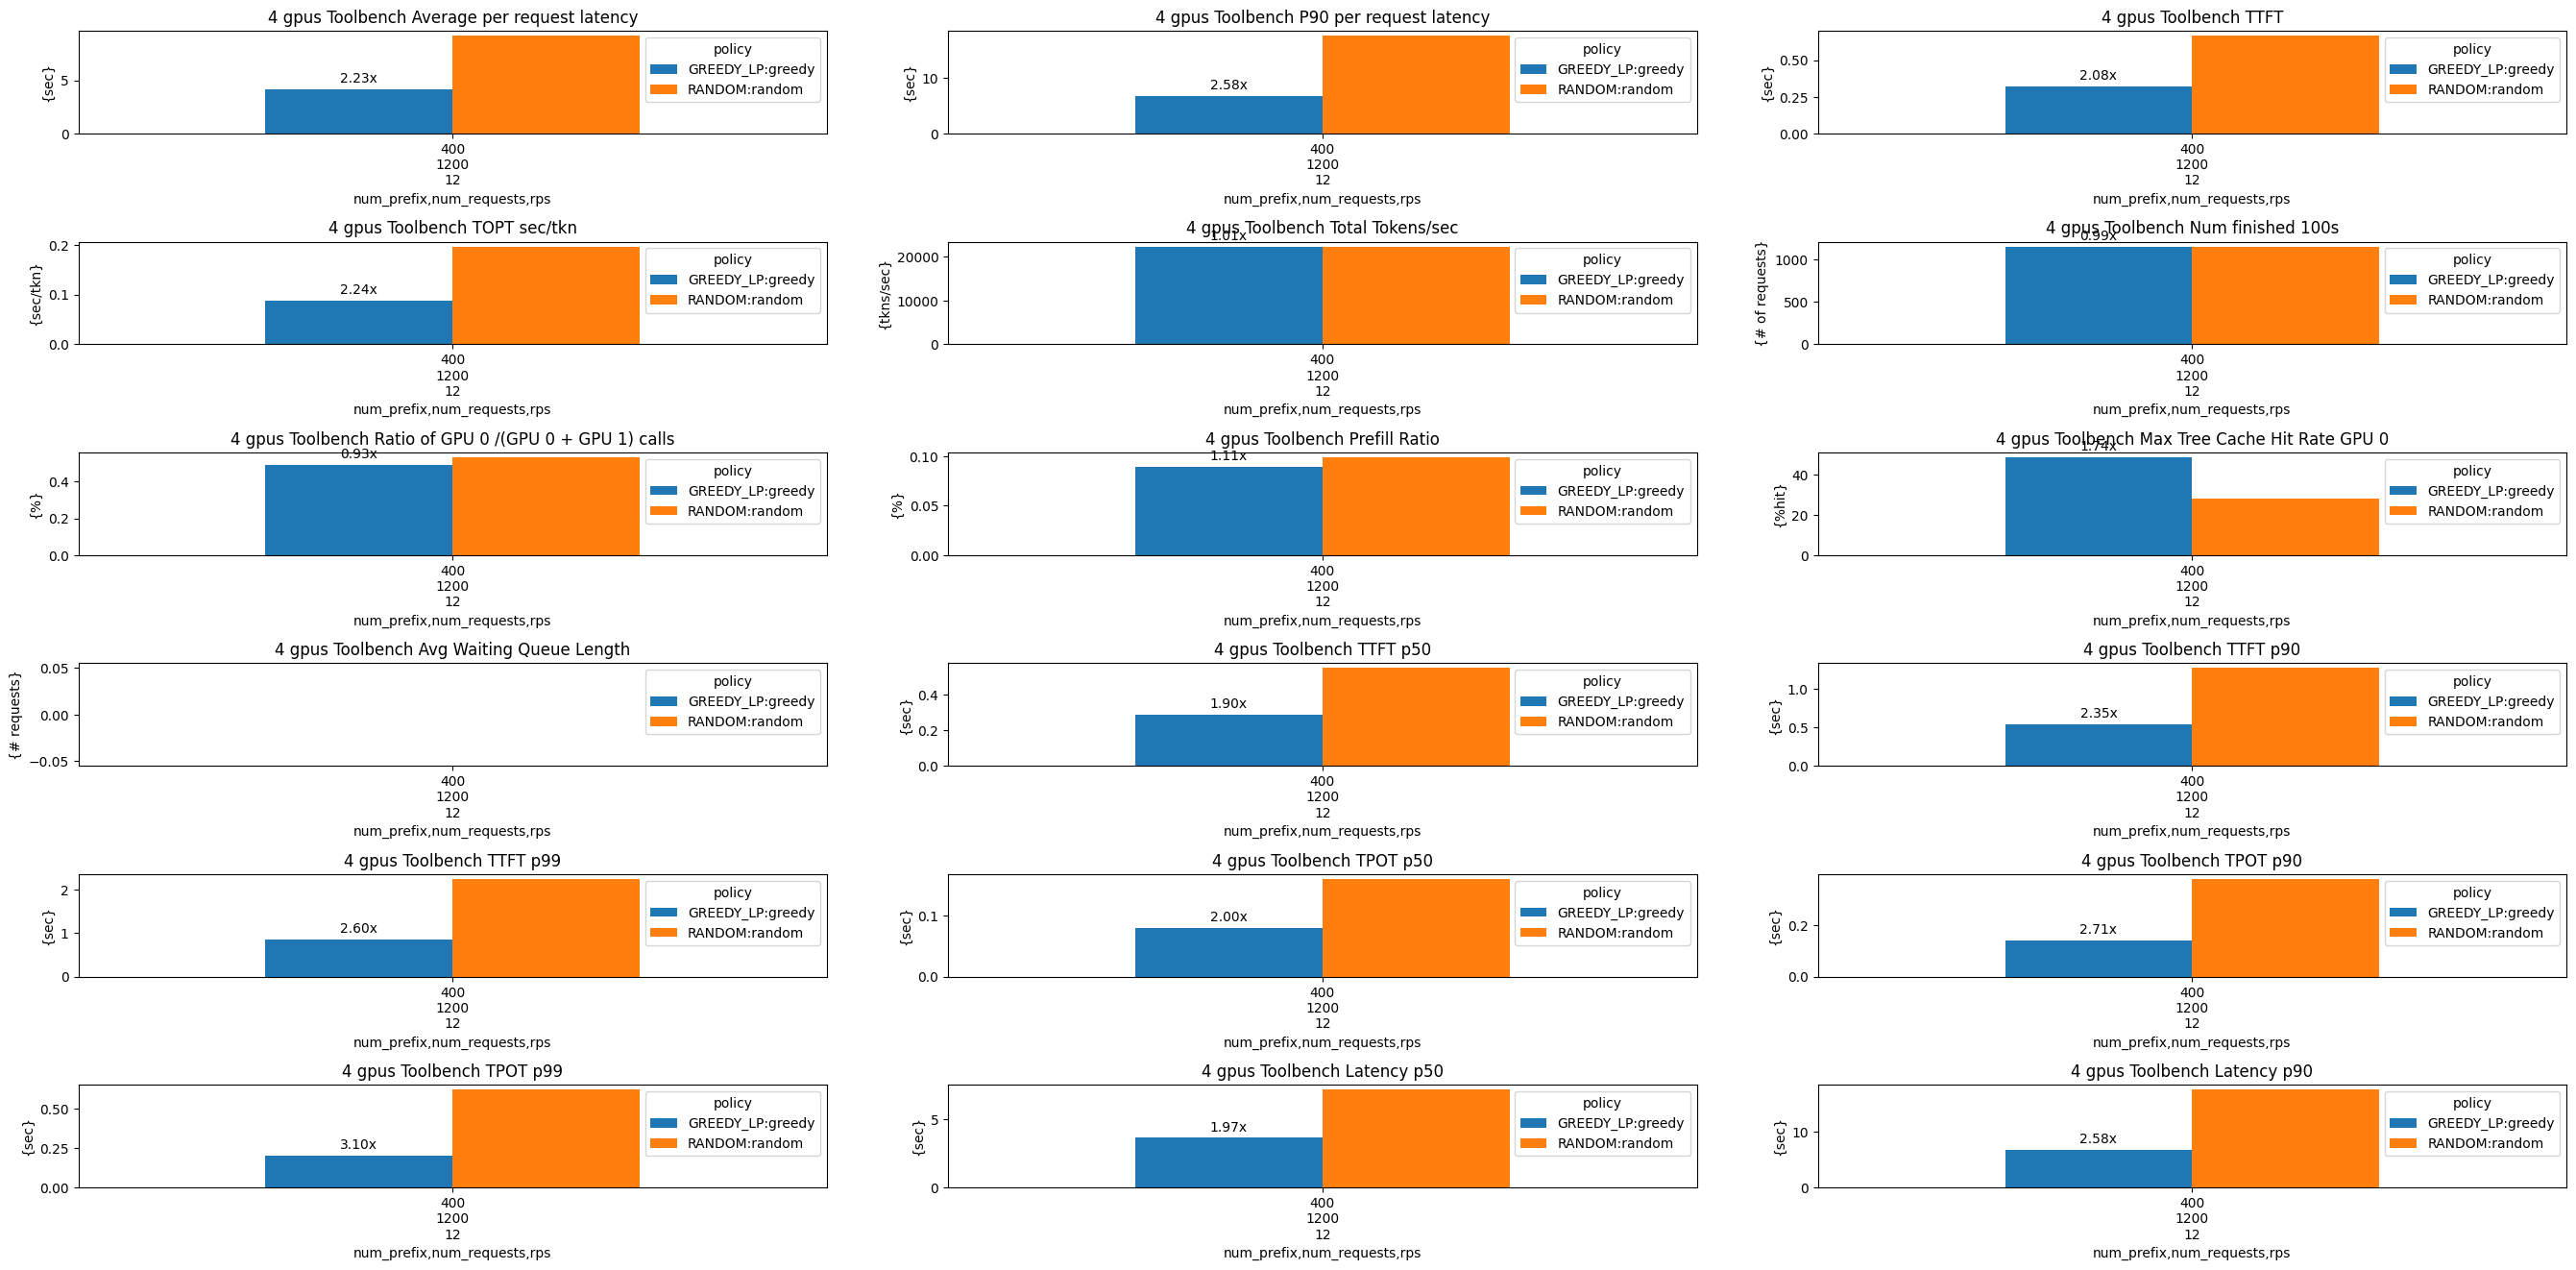

In [73]:
log_file = 'logs_sim/toolbench_4096_non_simulated_4_gpus.log'
param_keys = ["model_name", "num_prefix", "percent_random_prefixes", "num_requests", "rps", "policy", "exp_time"]
metrics = extract_metrics(log_file, param_keys, max_gpus=4)
node_3_exp = {}
plot_metrics(metrics, "4 gpus Toolbench", global_metric_dfs=node_3_exp, baseline_key="RANDOM:random", ax_dims=(6,3))

{'policy': 'DataParallelRuntimeSelectionPolicy.CUSTOM-CustomPolicyType.GREEDY_LP:greedy', 'num_prefix': '200', 'percent_random_prefixes': 0.0, 'num_requests': '600', 'rps': '6', 'max_tree_cache_hit_rate_gpu0': 50.22, 'max_tree_cache_hit_rate_gpu1': 47.42, 'avg_waiting_queue_len': 0.0}
{'policy': 'DataParallelRuntimeSelectionPolicy.RANDOM-:random', 'num_prefix': '200', 'percent_random_prefixes': 0.0, 'num_requests': '600', 'rps': '6', 'max_tree_cache_hit_rate_gpu0': 35.08, 'max_tree_cache_hit_rate_gpu1': 37.88, 'avg_waiting_queue_len': 0.0}


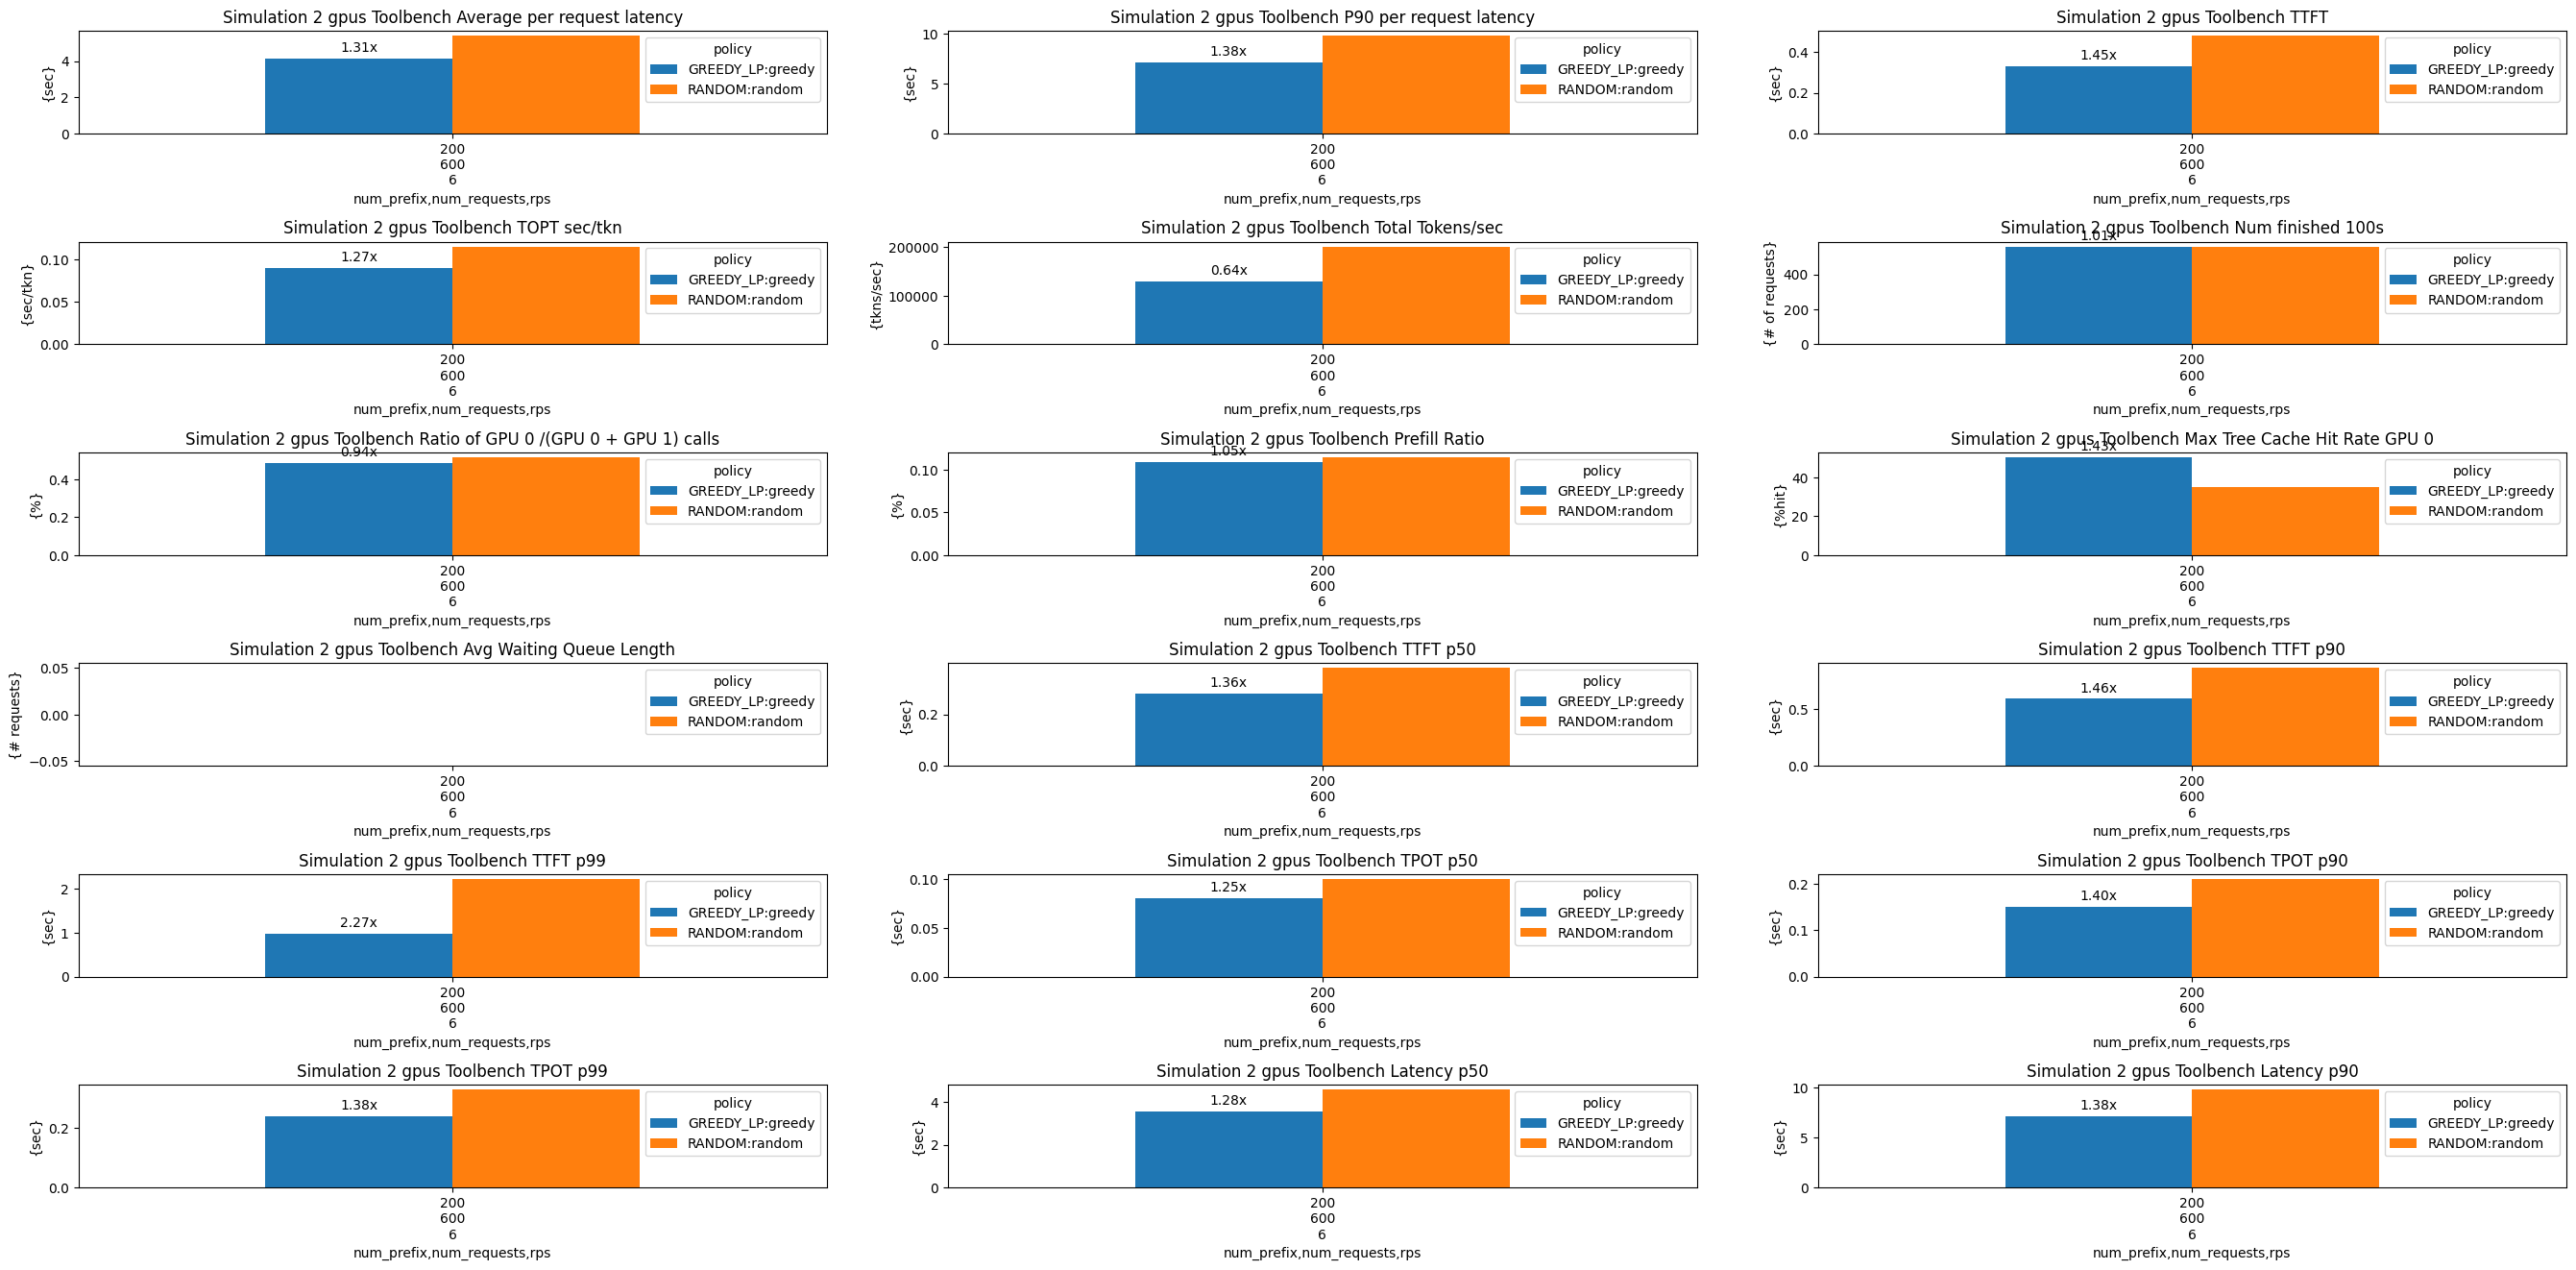

In [72]:
log_file = 'logs_sim/toolbench_4096_simulated_2_gpus.log'
param_keys = ["model_name", "num_prefix", "percent_random_prefixes", "num_requests", "rps", "policy", "exp_time"]
metrics = extract_metrics(log_file, param_keys, max_gpus=2)
node_3_exp = {}
plot_metrics(metrics, "Simulation 2 gpus Toolbench", global_metric_dfs=node_3_exp, baseline_key="RANDOM:random", ax_dims=(6,3))

{'policy': 'DataParallelRuntimeSelectionPolicy.RANDOM-None:4r', 'num_prefix': '200', 'percent_random_prefixes': 0.5, 'num_requests': '32400', 'rps': '18', 'max_tree_cache_hit_rate_gpu0': 10.12, 'max_tree_cache_hit_rate_gpu1': 9.85, 'max_tree_cache_hit_rate_gpu2': 11.04, 'max_tree_cache_hit_rate_gpu3': 9.45, 'avg_waiting_queue_len': 1049.161963190184}
{'policy': 'DataParallelRuntimeSelectionPolicy.CUSTOM-CustomPolicyType.ORACLE:4r', 'num_prefix': '200', 'percent_random_prefixes': 0.5, 'num_requests': '32400', 'rps': '18', 'max_tree_cache_hit_rate_gpu0': 25.8, 'max_tree_cache_hit_rate_gpu1': 25.09, 'max_tree_cache_hit_rate_gpu2': 27.06, 'max_tree_cache_hit_rate_gpu3': 23.4, 'avg_waiting_queue_len': 561.9276769741886}
{'policy': 'DataParallelRuntimeSelectionPolicy.CUSTOM-CustomPolicyType.ORACLE_HOT_COLD:4r_2h_2c', 'num_prefix': '200', 'percent_random_prefixes': 0.5, 'num_requests': '32400', 'rps': '18', 'max_tree_cache_hit_rate_gpu0': 78.74, 'max_tree_cache_hit_rate_gpu1': 81.88, 'max_tre

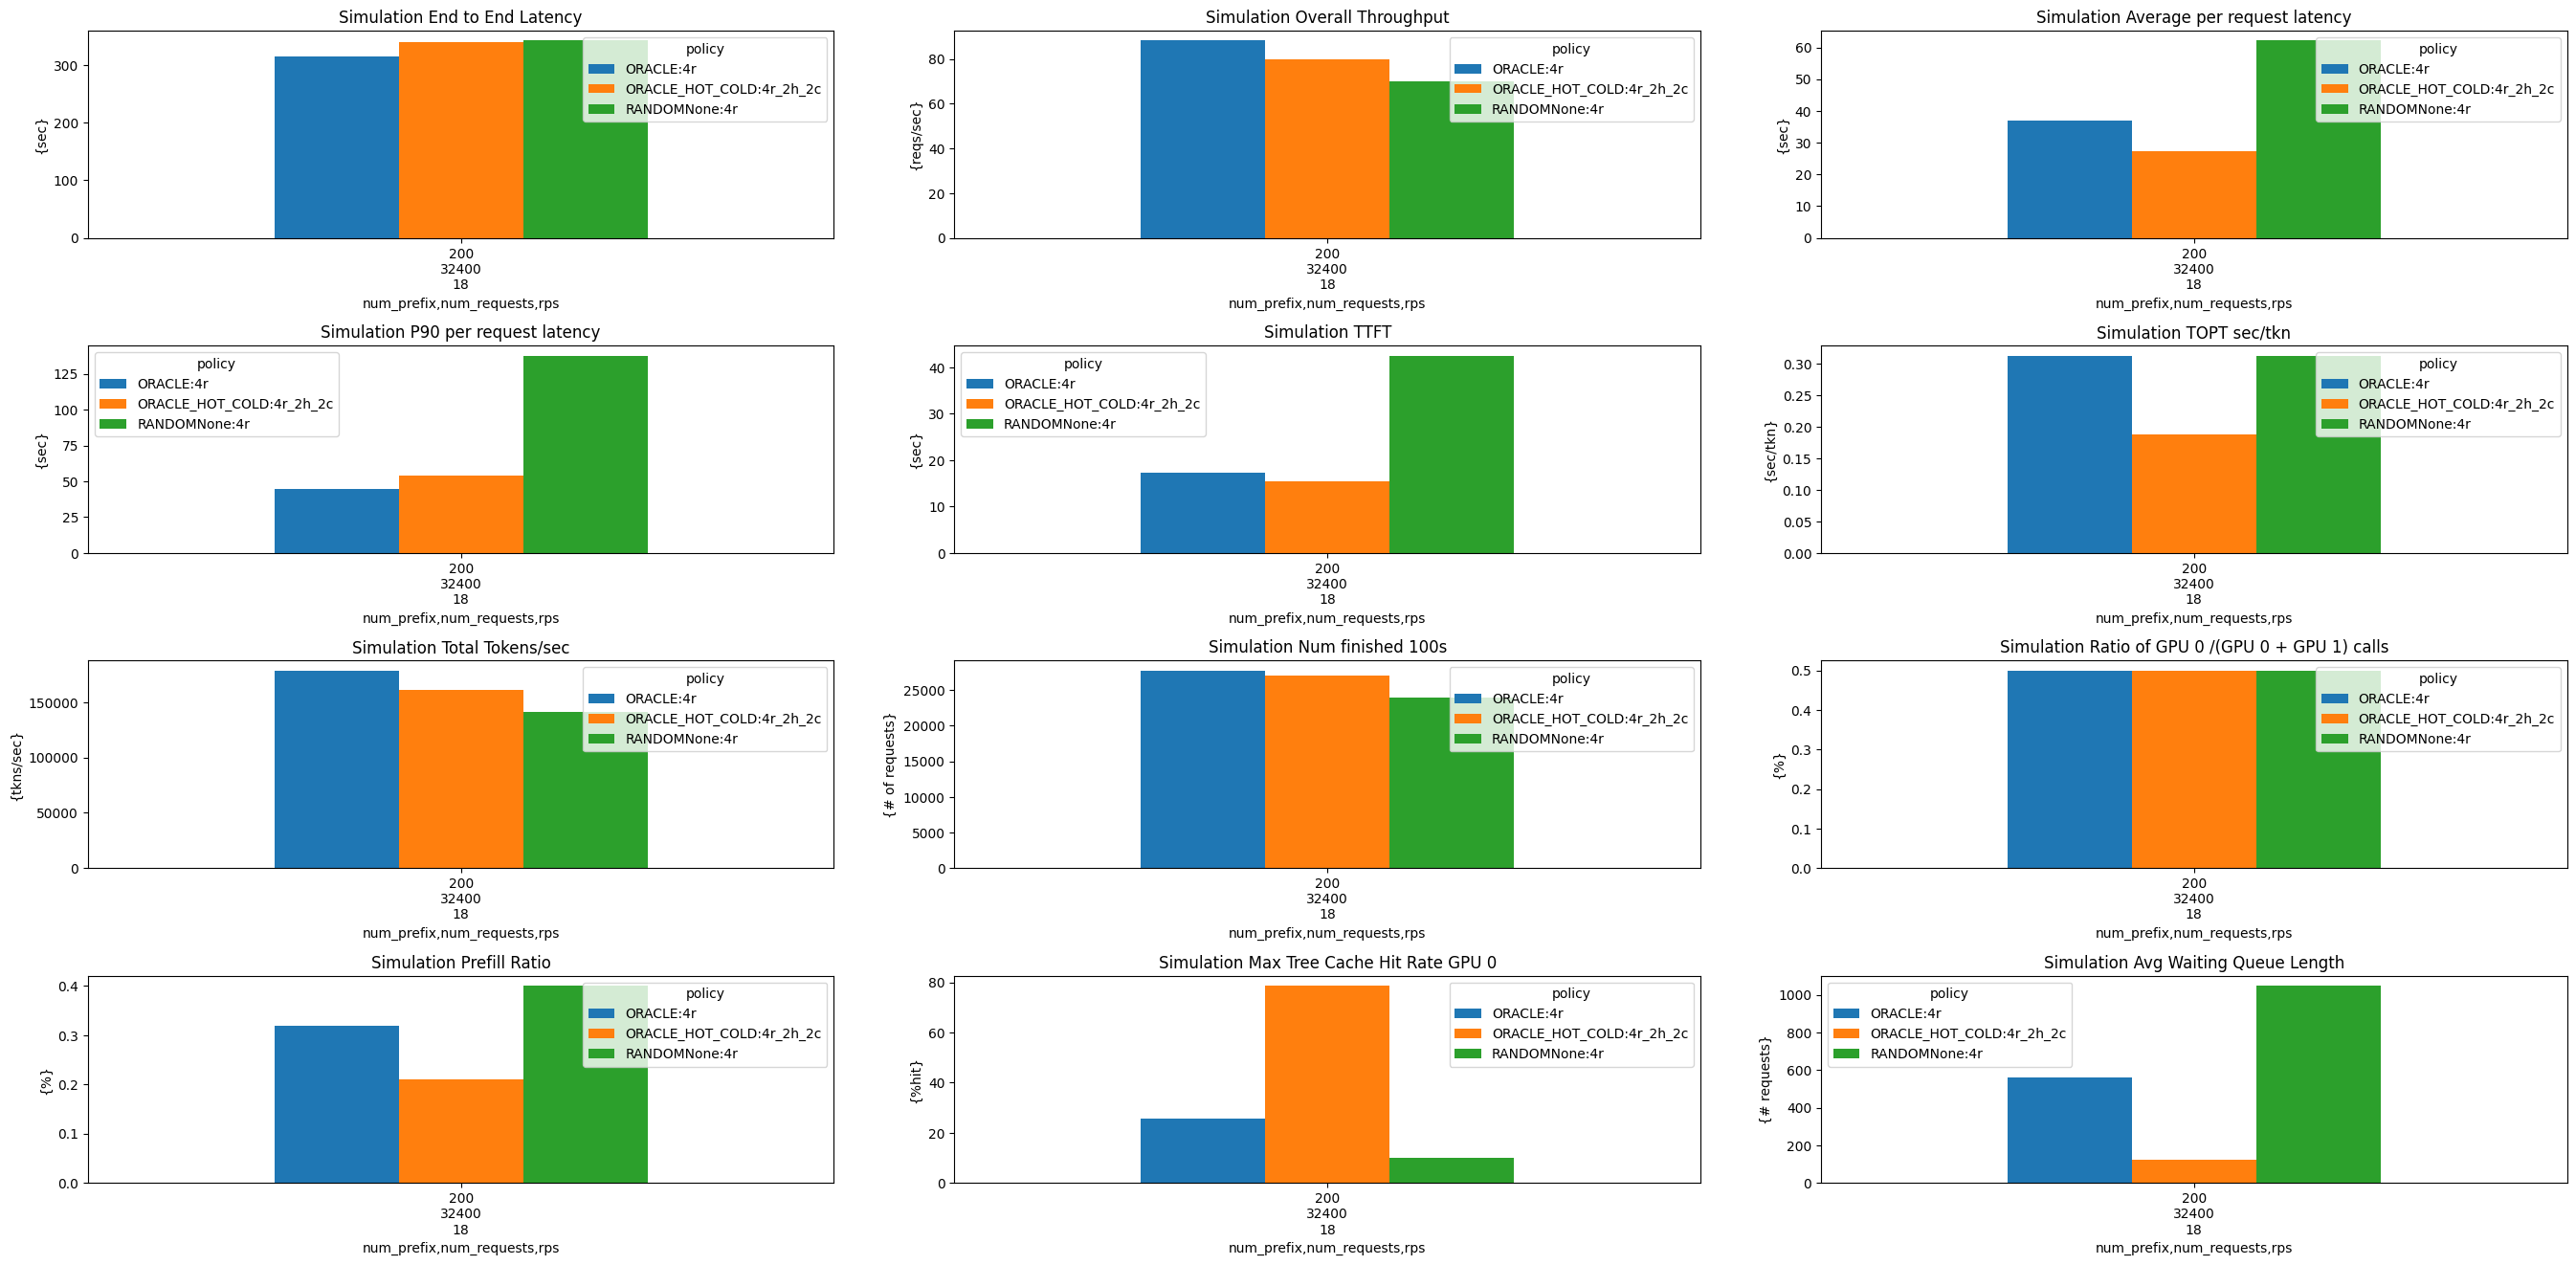

In [3]:
log_file = '/mnt/ssd1/alm-os/sglang_multi_model/logs/sim_hot_cold_rps18_1800.log'
param_keys = ["model_name", "num_prefix", "percent_random_prefixes", "num_requests", "rps", "policy", "exp_time"]
metrics = extract_metrics(log_file, param_keys, max_gpus=4)
node_3_exp = {}
plot_metrics(metrics, "Simulation", global_metric_dfs=node_3_exp)

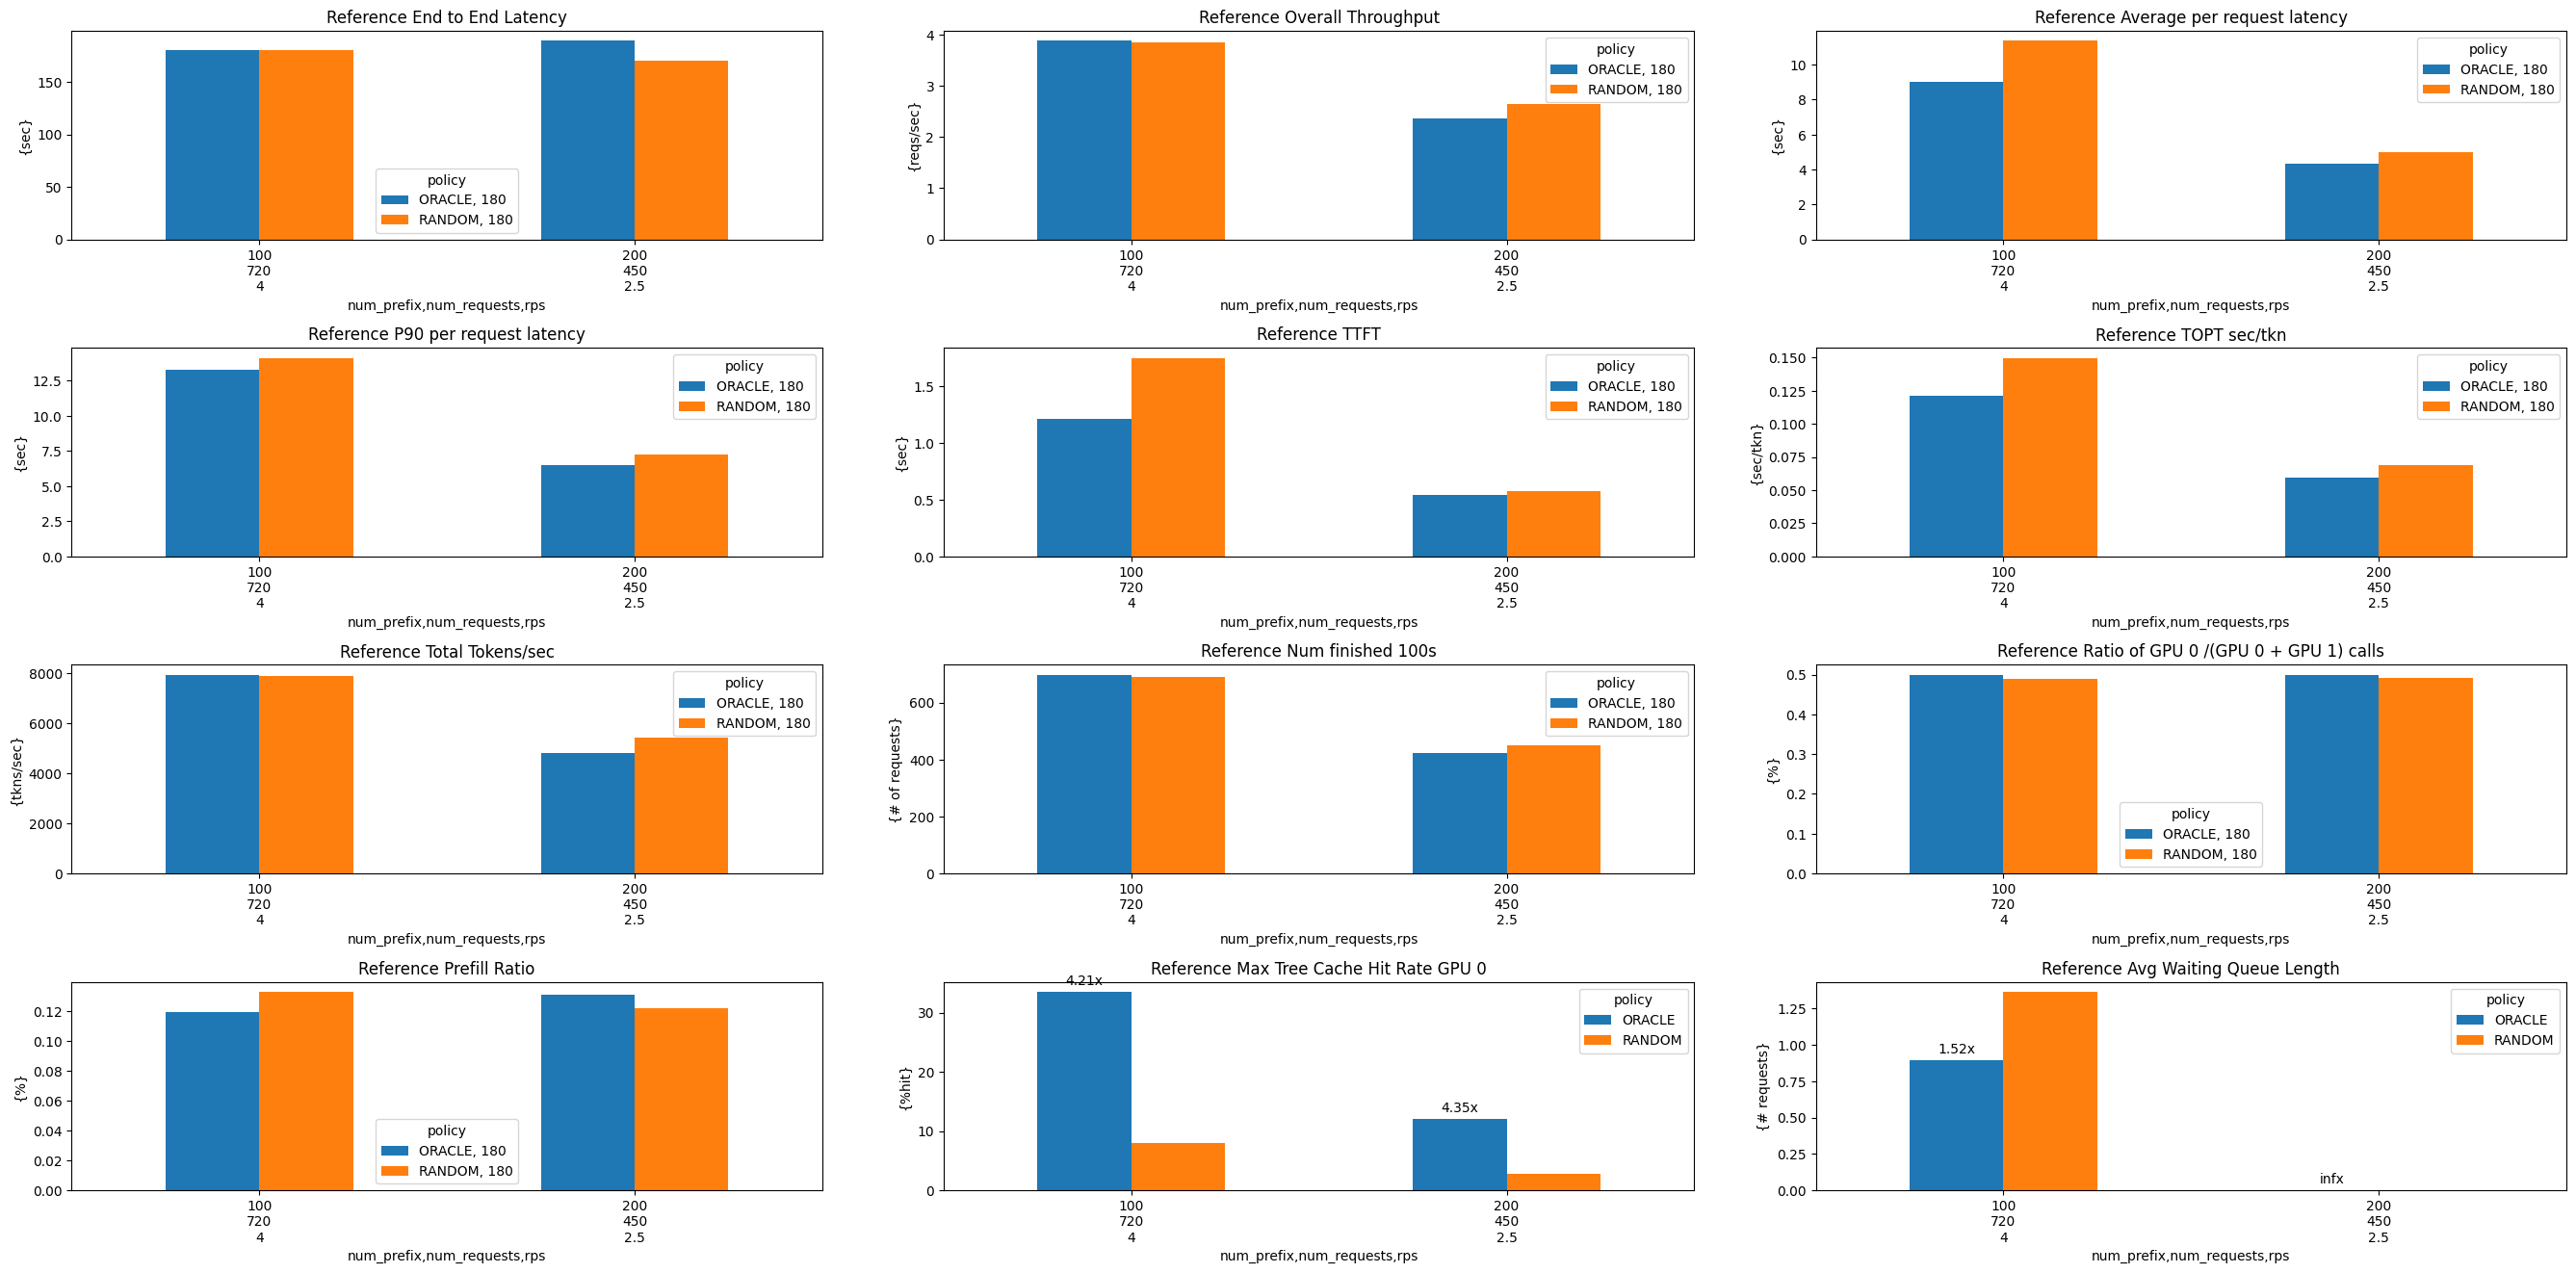

In [ ]:
log_file = '/mnt/ssd1/alm-os/sglang_multi_model/ref_for_sim_2048.log'
param_keys = ["model_name", "num_prefix", "percent_random_prefixes", "num_requests", "rps", "policy"]
metrics = extract_metrics(log_file, param_keys, max_gpus=2)
node_4_exp = {}
plot_metrics(metrics, "Reference", global_metric_dfs=node_4_exp)

In [4]:
indices_to_compare = [('200', '4096', '8')]
compare_two_plots(node_3_exp,
                  node_4_exp,
                  indices_to_compare, 
                  title_prefix="Node 3 vs Node 4 at (200, 4096, 8) Version 1", 
                  labels=['ORACLE_B', 'RANDOM', 'speedup_over_random'], 
                  exp1_title="Node 3",
                  exp2_title="Node 4")

NameError: name 'node_3_exp' is not defined

In [5]:
log_file = '3_node_experiments_verify2.log'
param_keys = ["model_name", "num_prefix", "percent_random_prefixes", "num_requests", "rps", "policy", "exp_time"]
metrics = extract_metrics(log_file, param_keys, max_gpus=3)
node_3_exp = {}
plot_metrics(metrics, "3 Node Exp Version 2", global_metric_dfs=node_3_exp)

log_file = '4_node_experiments_verify2.log'
param_keys = ["model_name", "num_prefix", "percent_random_prefixes", "num_requests", "rps", "policy", "exp_time"]
metrics = extract_metrics(log_file, param_keys, max_gpus=3)
node_4_exp = {}
plot_metrics(metrics, "4 Node Exp Version 2", global_metric_dfs=node_4_exp)

indices_to_compare = [('200', '4096', '8')]
compare_two_plots(node_3_exp,
                  node_4_exp,
                  indices_to_compare, 
                  title_prefix="Node 3 vs Node 4 at (200, 4096, 8) Version 2", 
                  labels=['TBORACLE_B', 'RANDOM', 'speedup_over_random'], 
                  exp1_title="Node 3",
                  exp2_title="Node 4")

FileNotFoundError: [Errno 2] No such file or directory: '3_node_experiments_verify2.log'

In [6]:
log_file = '2_node_experiments_verify2.log'
param_keys = ["model_name", "num_prefix", "percent_random_prefixes", "num_requests", "rps", "policy", "exp_time"]
metrics = extract_metrics(log_file, param_keys, max_gpus=3)
node_2_exp = {}
plot_metrics(metrics, "2 Node Exp Version 2", global_metric_dfs=node_2_exp, global_metric_columns=['TBORACLE_B', 'RANDOM'])

FileNotFoundError: [Errno 2] No such file or directory: '2_node_experiments_verify2.log'

In [7]:
indices_to_compare = [
    ('200', '4096', '6'),
    ('200', '4096', '8'),
    ('200', '4096', '8'),
]
compare_n_plots(
    [node_2_exp, node_3_exp, node_4_exp],
    ["Node2", "Node 3", "Node 4"],
    indices_to_compare,
    title_prefix="Node2(200, 4096, 6), Node 3 & Node 4 at (200, 4096, 8)\n ",
    labels=['TBORACLE_B', 'RANDOM', 'speedup_over_random']
)

NameError: name 'node_2_exp' is not defined

{'policy': 'DataParallelRuntimeSelectionPolicy.CUSTOM-CustomPolicyType.MemSchedulerEvictBasedOnLoad:evict_based_on_load', 'num_prefix': '200', 'percent_random_prefixes': 0.0, 'num_requests': '1200', 'rps': '6', 'max_tree_cache_hit_rate_gpu0': 59.78, 'max_tree_cache_hit_rate_gpu1': 58.98, 'avg_waiting_queue_len': 0.0}
{'policy': 'DataParallelRuntimeSelectionPolicy.CUSTOM-CustomPolicyType.BASIC_MEM_SCHEDULERV2:mem_basic_v2', 'num_prefix': '200', 'percent_random_prefixes': 0.0, 'num_requests': '1200', 'rps': '6', 'max_tree_cache_hit_rate_gpu0': 57.39, 'max_tree_cache_hit_rate_gpu1': 60.23, 'avg_waiting_queue_len': 0.0}
{'policy': 'DataParallelRuntimeSelectionPolicy.CUSTOM-CustomPolicyType.BASIC_MEM_SCHEDULERV2:mem_basic_v2', 'num_prefix': '200', 'percent_random_prefixes': 0.0, 'num_requests': '1200', 'rps': '6', 'max_tree_cache_hit_rate_gpu0': 56.93, 'max_tree_cache_hit_rate_gpu1': 60.4, 'avg_waiting_queue_len': 0.0}
{'policy': 'DataParallelRuntimeSelectionPolicy.CUSTOM-CustomPolicyType.M

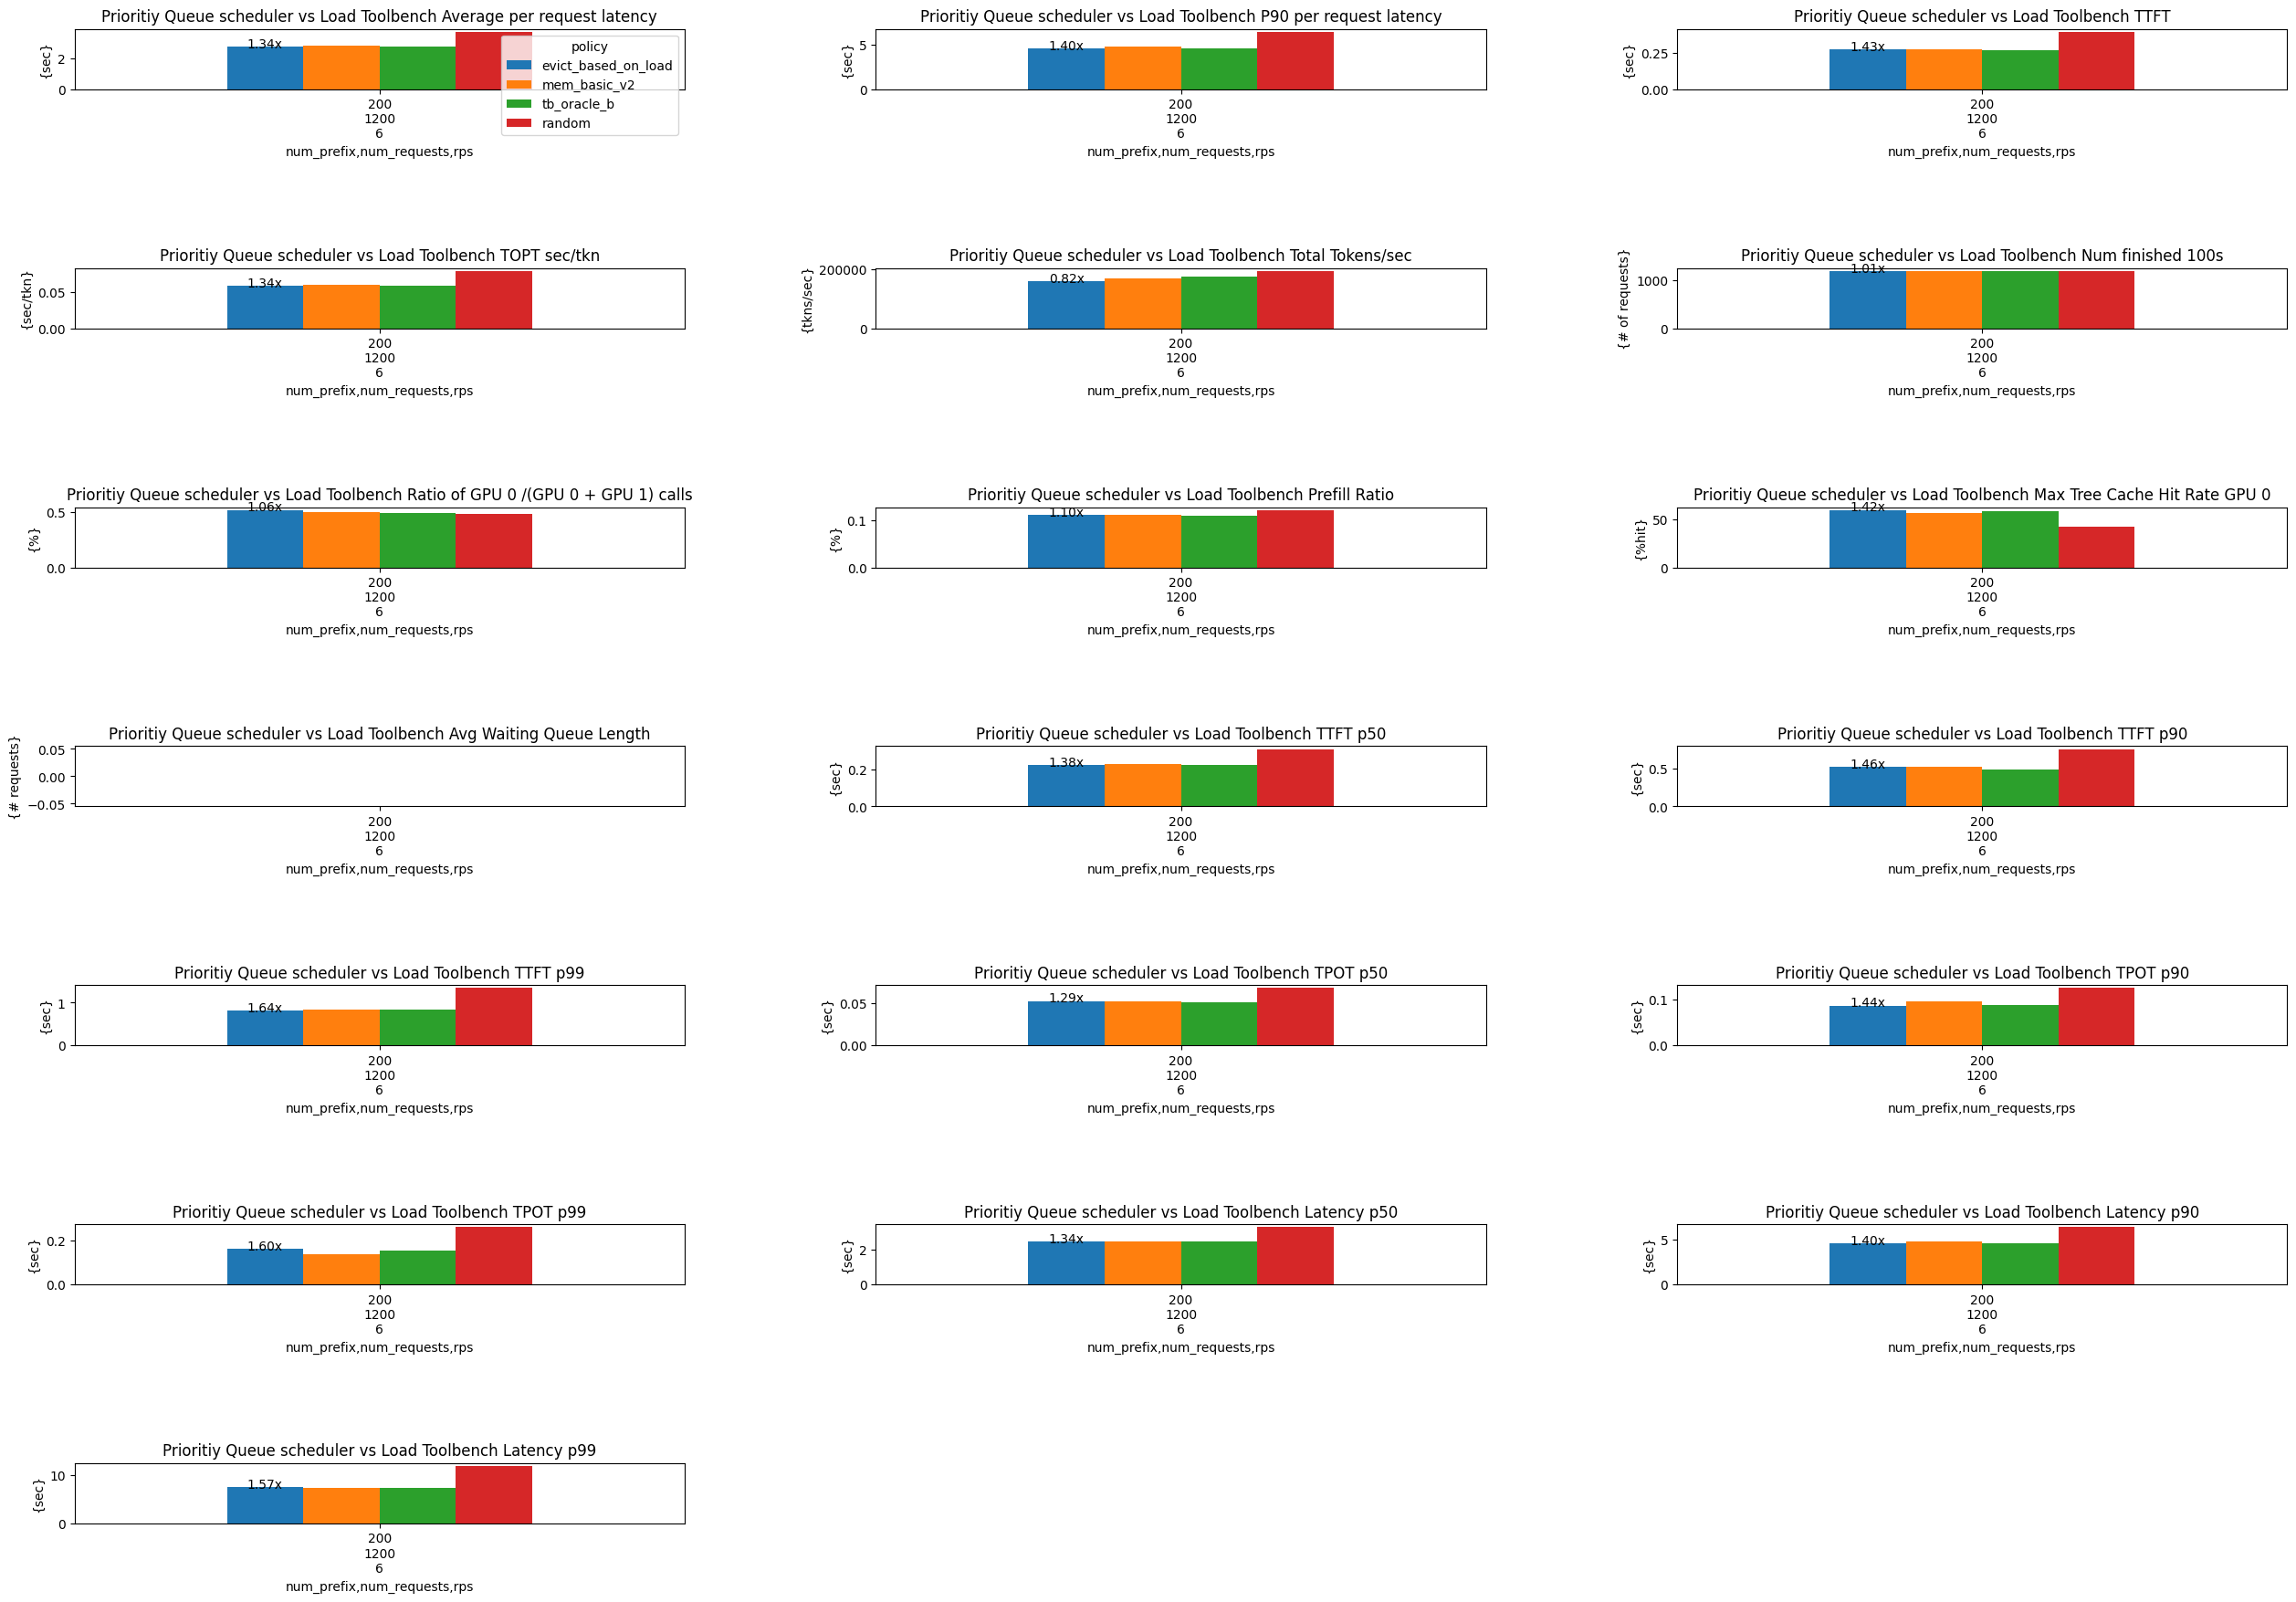

In [31]:
log_file = "evict_based_load/toolbench_mem_and_evict.log"
param_keys = ["model_name", "num_prefix", "percent_random_prefixes", "num_requests", "rps", "policy", "exp_time"]
metrics = extract_metrics(log_file, param_keys, max_gpus=2)
lp_scheduler_exp = {}
plot_metrics(metrics, "Prioritiy Queue scheduler vs Load Toolbench", global_metric_dfs=lp_scheduler_exp, baseline_key="random", 
            global_metric_columns=["evict_based_on_load", "mem_basic_v2", "tb_oracle_b", "random"], ax_dims=(7, 3), figsize=(28, 20))

{'policy': 'DataParallelRuntimeSelectionPolicy.CUSTOM-CustomPolicyType.MemSchedulerEvictBasedOnLoad:evict_based_on_load', 'num_prefix': '200', 'percent_random_prefixes': 0.0, 'num_requests': '1200', 'rps': '6', 'max_tree_cache_hit_rate_gpu0': 62.75, 'max_tree_cache_hit_rate_gpu1': 64.29, 'avg_waiting_queue_len': 0.0}
{'policy': 'DataParallelRuntimeSelectionPolicy.CUSTOM-CustomPolicyType.BASIC_MEM_SCHEDULERV2:mem_basic_v2', 'num_prefix': '200', 'percent_random_prefixes': 0.0, 'num_requests': '1200', 'rps': '6', 'max_tree_cache_hit_rate_gpu0': 63.16, 'max_tree_cache_hit_rate_gpu1': 62.11, 'avg_waiting_queue_len': 0.0}
{'policy': 'DataParallelRuntimeSelectionPolicy.CUSTOM-CustomPolicyType.BASIC_MEM_SCHEDULERV2:mem_basic_v2', 'num_prefix': '200', 'percent_random_prefixes': 0.0, 'num_requests': '1200', 'rps': '6', 'max_tree_cache_hit_rate_gpu0': 63.12, 'max_tree_cache_hit_rate_gpu1': 62.14, 'avg_waiting_queue_len': 0.0}
{'policy': 'DataParallelRuntimeSelectionPolicy.CUSTOM-CustomPolicyType.

/tmp/ipykernel_2803665/1281631842.py:277: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(pad=12.0)


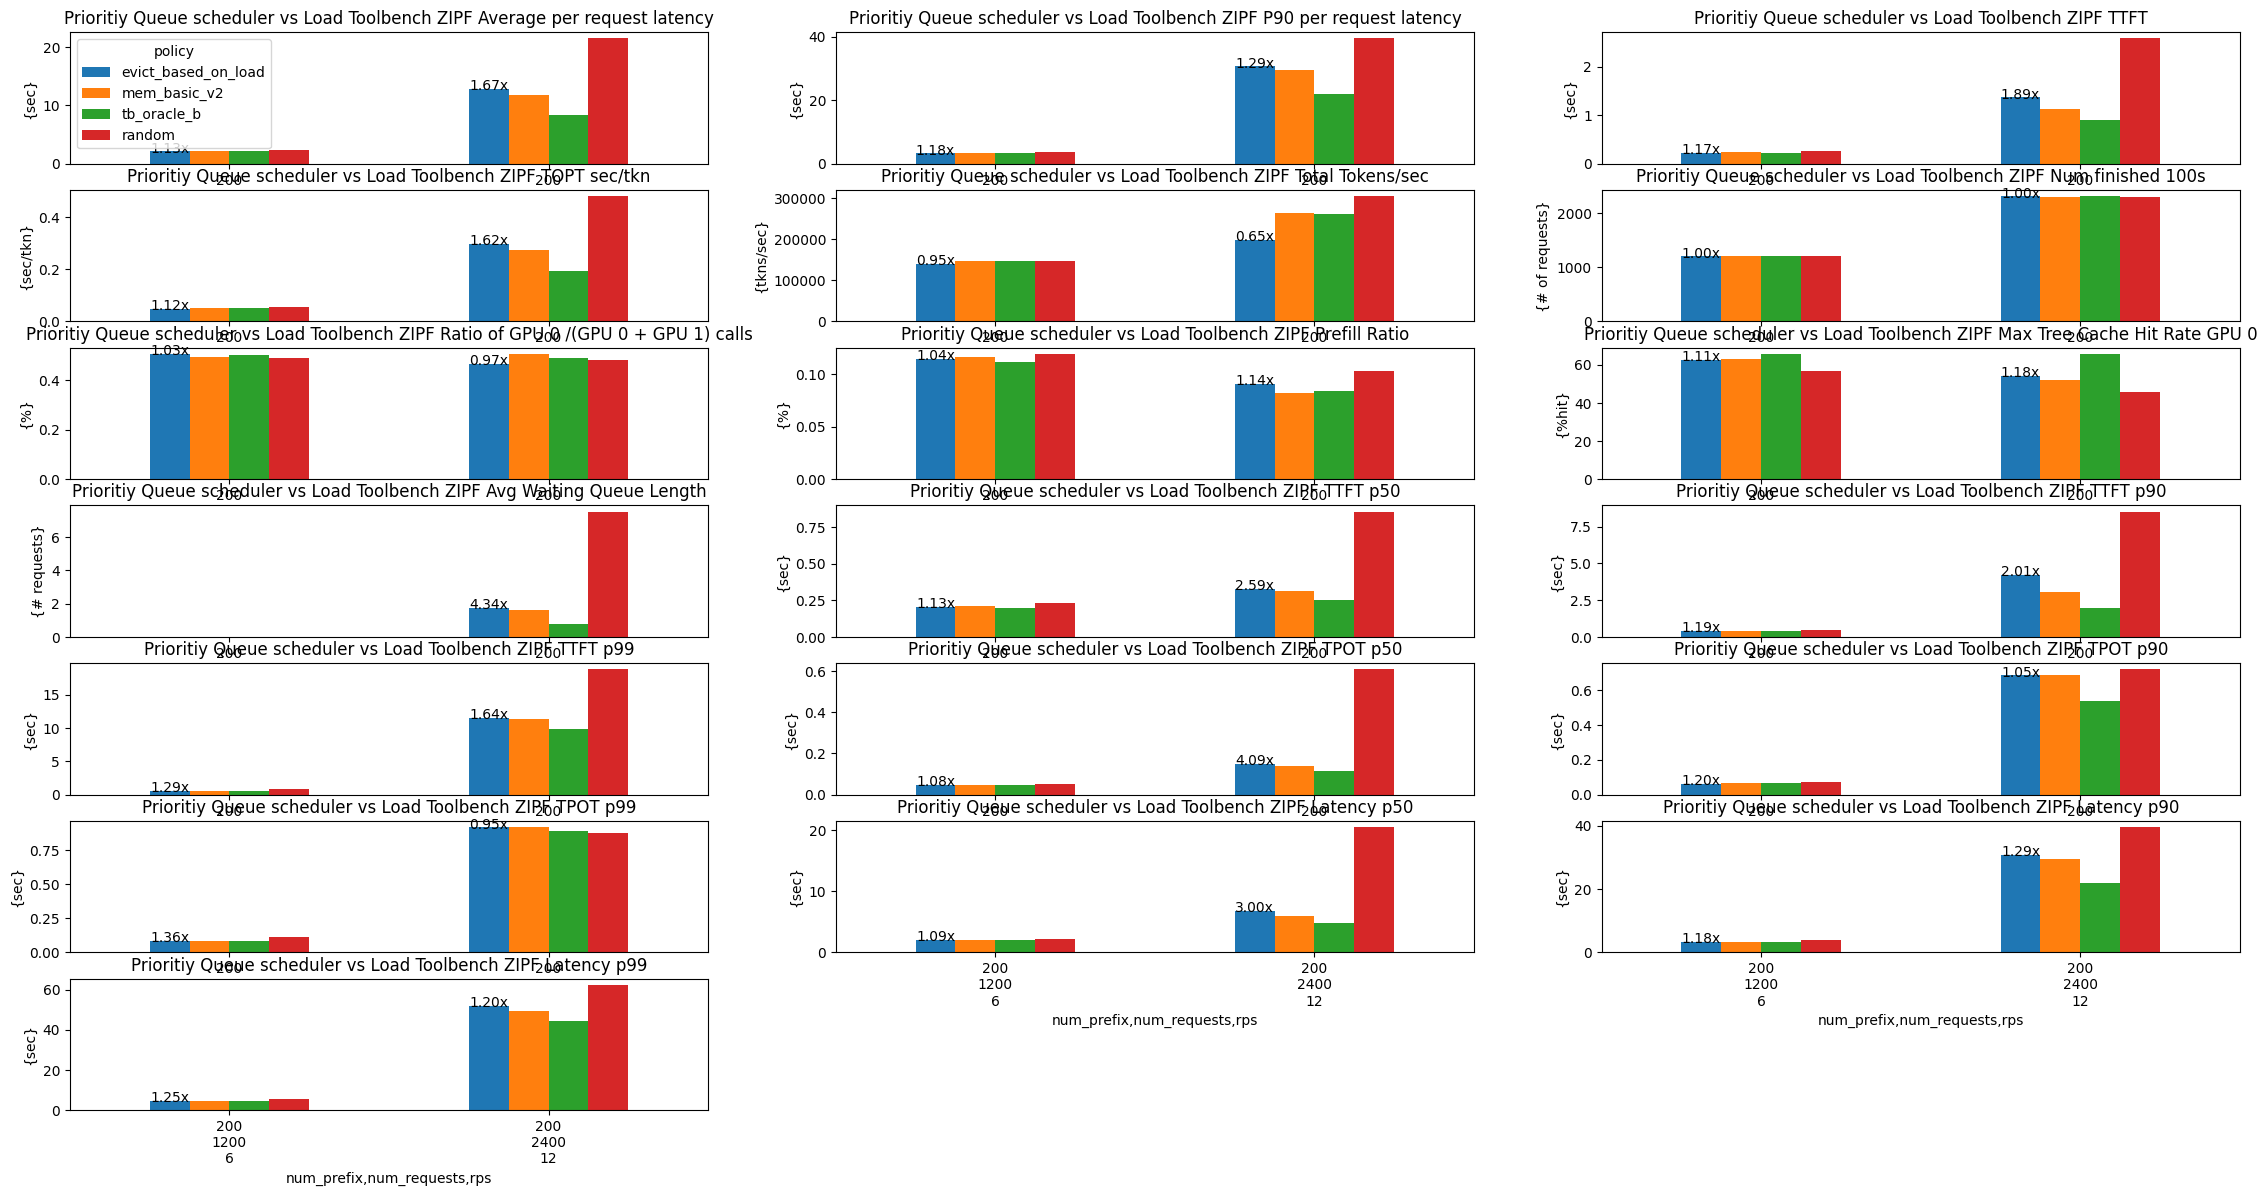

In [32]:
log_file = "evict_based_load/toolbench_mem_and_evict_zipf.log"
param_keys = ["model_name", "num_prefix", "percent_random_prefixes", "num_requests", "rps", "policy", "exp_time"]
metrics = extract_metrics(log_file, param_keys, max_gpus=2)
lp_scheduler_exp = {}
plot_metrics(metrics, "Prioritiy Queue scheduler vs Load Toolbench ZIPF", global_metric_dfs=lp_scheduler_exp, baseline_key="random", 
            global_metric_columns=["evict_based_on_load", "mem_basic_v2", "tb_oracle_b", "random"], ax_dims=(7, 3))

In [8]:
log_file = "lp_scheduler_3_node.log"
param_keys = ["model_name", "num_prefix", "percent_random_prefixes", "num_requests", "rps", "policy", "exp_time"]
metrics = extract_metrics(log_file, param_keys, max_gpus=3)
lp_scheduler_exp = {}
plot_metrics(metrics, "LP Scheduler 3 Node", global_metric_dfs=lp_scheduler_exp, global_metric_columns=['LP_SCHEDULER', 'TBORACLE_B', 'RANDOM'])

FileNotFoundError: [Errno 2] No such file or directory: 'lp_scheduler_3_node.log'

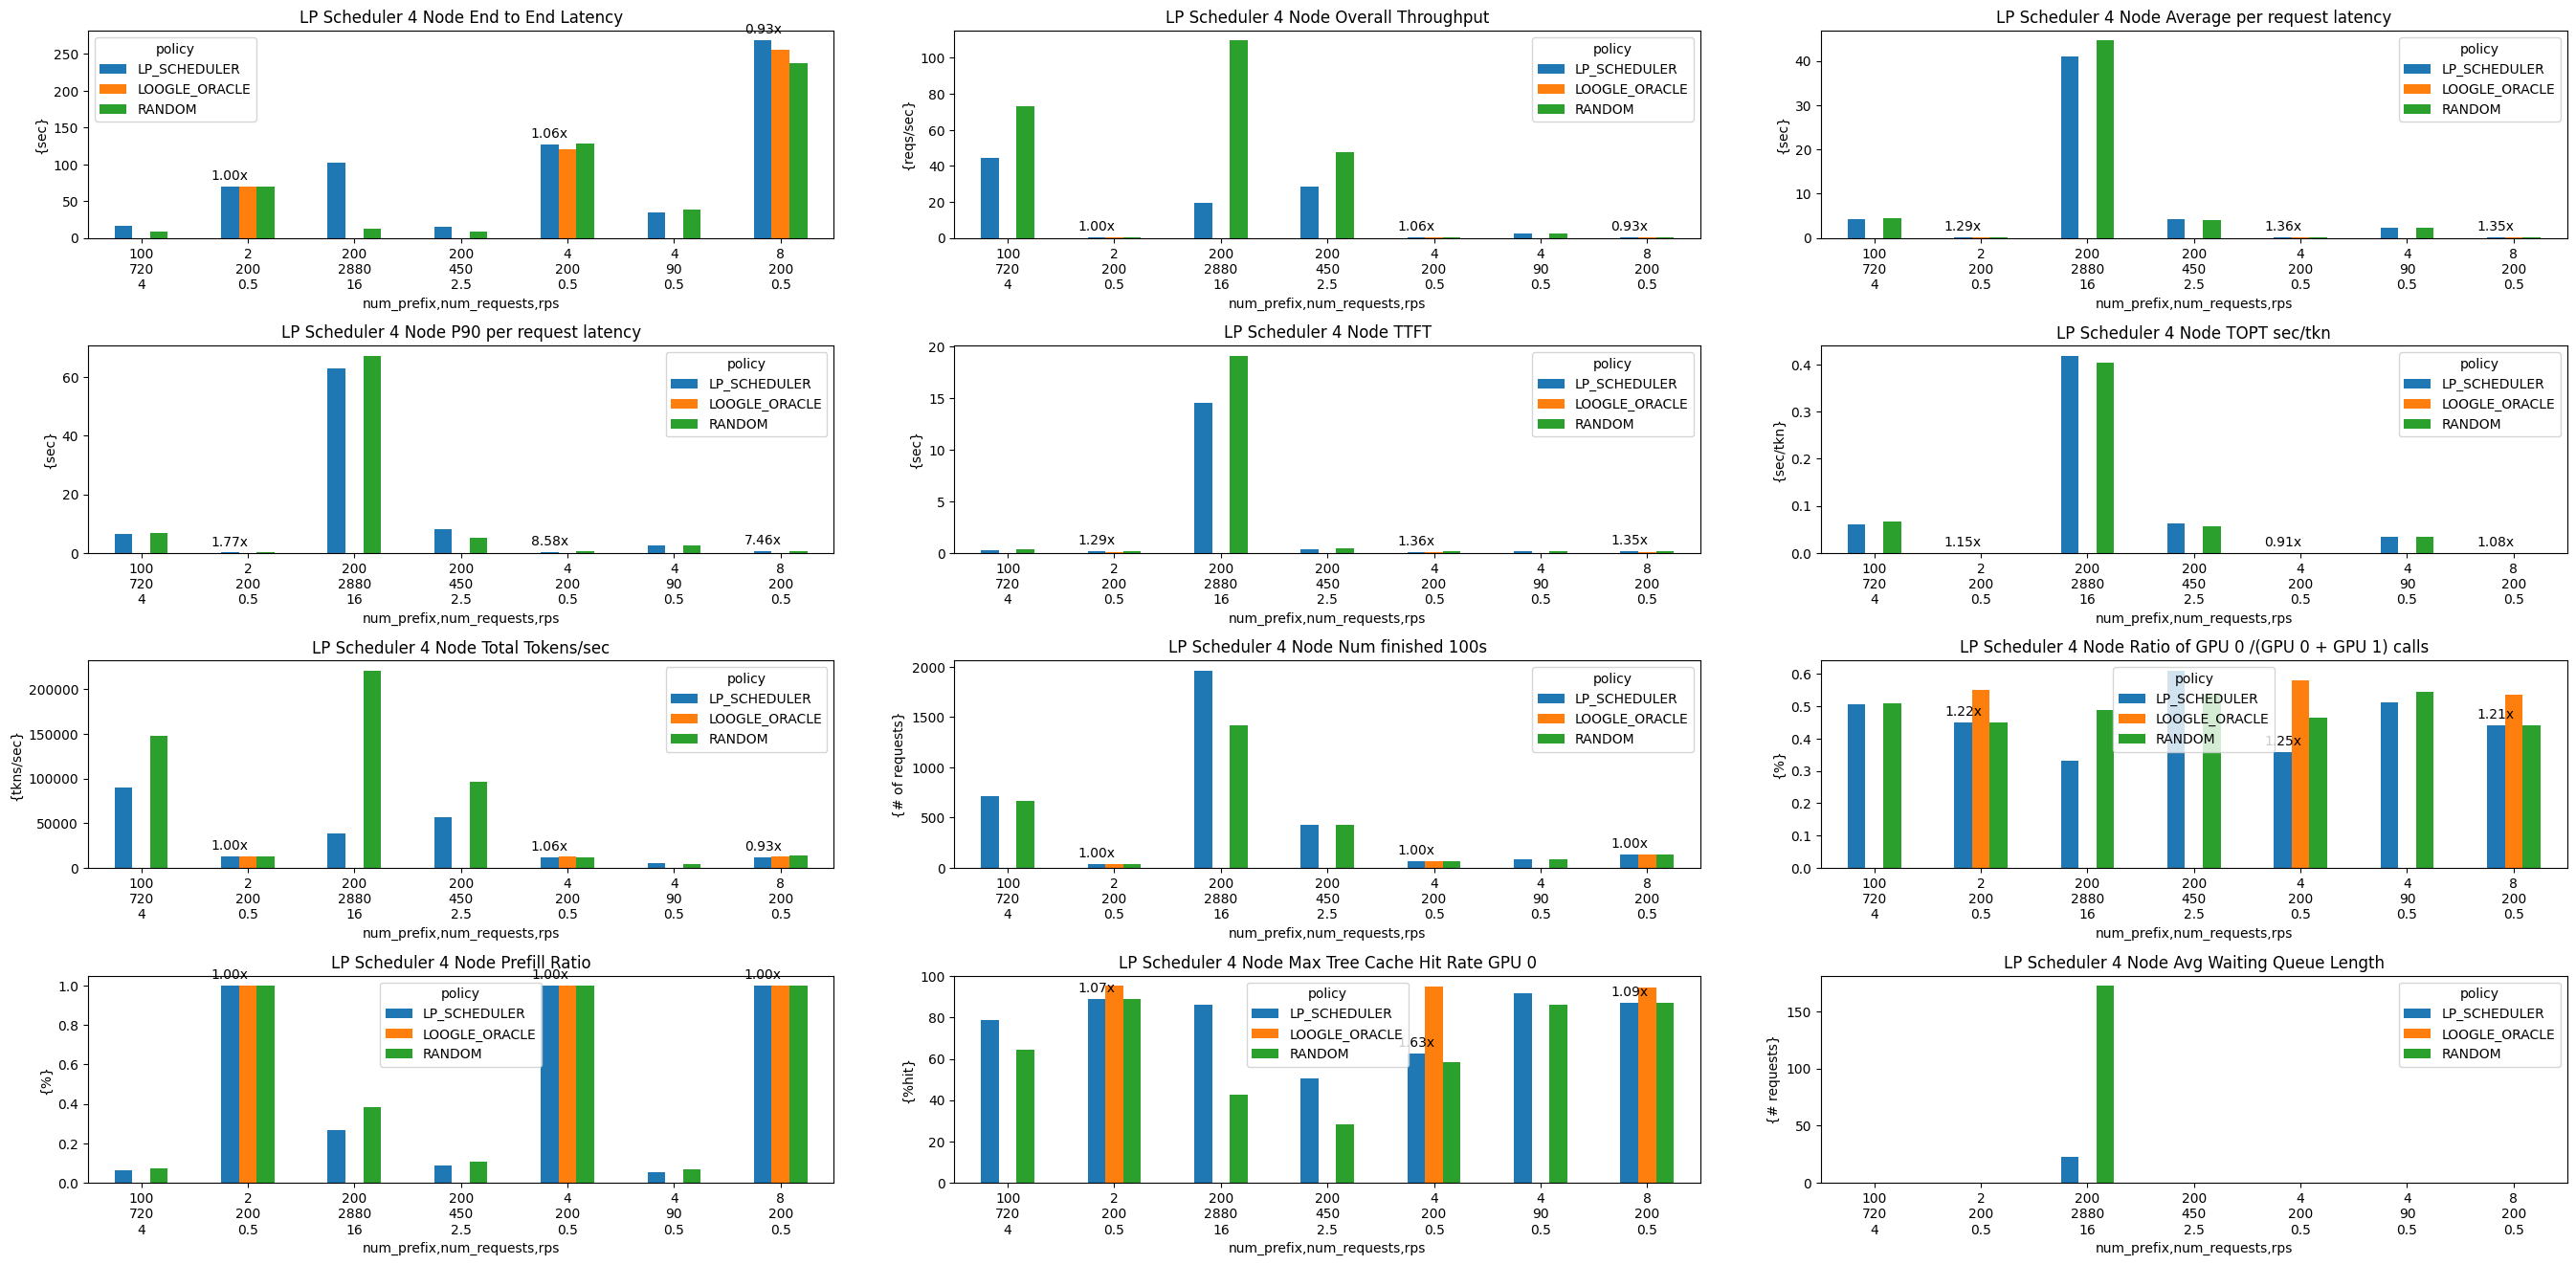

In [11]:
log_file = "lp_scheduler_debug.log"
param_keys = ["model_name", "num_prefix", "percent_random_prefixes", "num_requests", "rps", "policy", "exp_time"]
metrics = extract_metrics(log_file, param_keys, max_gpus=4)
lp_scheduler_exp = {}
plot_metrics(metrics, "LP Scheduler 4 Node", global_metric_dfs=lp_scheduler_exp, global_metric_columns=['LP_SCHEDULER',  'LOOGLE_ORACLE', 'RANDOM'])